***
*Project:* Helmholtz Machine

*Author:* Jingwei Liu, Computer Music Ph.D., UC San Diego
***

# <span style="background-color:darkorange; color:white; padding:2px 6px">MHM Pre</span> 

# Helmholtz Machine


*Created:* April 13, 2025


In [141]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
torch.cuda.is_available()

True

In [142]:
def para_init(n_dz,dev):
    """
    Arguments:
    n_dz -- torch tensor of size len(n_dz)
    init_type -- "zero"

    Returns:
    Phi, Theta -- set of parameters for hierarchical layers
    """
    Phi = {}
    Theta = {}
    l = len(n_dz)
    for i in range(l-2):
        Phi["Phi_" + str(i) + str(i+1)] = torch.zeros((n_dz[i+1],n_dz[i]),device=dev)
    for i in range(l-1,0,-1):
        Theta["Theta_" + str(i) + str(i-1)] = torch.zeros((n_dz[i-1],n_dz[i]),device=dev)
    return Phi,Theta

In [143]:
def sigmoid(x):
    """
    Arguments:
    x -- torch tensor of shape (n,batch_size)
    
    Returns:
    p -- probability of layer y, torch tensor of shape (n,batch_size)
    """
    p = 1/(1+torch.exp(-x))
    return p

In [144]:
def one_step_forward(x,param):
    """
    Arguments:
    x -- input layer, torch tensor of shape (n_x,batch_size)
    param -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    
    Returns:
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    """
    q = sigmoid(torch.matmul(param,x.type(torch.float)))
    return q

In [145]:
def sample(q,dev):
    """
    Arguments:
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    dev -- device
    
    Returns:
    y -- instantiation of layer y, torch tensor of shape (n_y,batch_size)
    """
    y = (q > torch.rand(q.size(),device=dev)).long() # rejection sampling
    return y

In [146]:
def log(p):
    q = torch.where(p != 0, torch.log(p), -20) # replace log(0) with -100
    return q

In [147]:
def cross_entropy_loss(y,q):
    """
    Arguments:
    y -- output layer sample, torch tensor of shape (n_y,batch_size)
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    
    Returns:
    loss -- cross entropy loss, L = -(y.*log(q)+(1-y).*log(1-q)).mean()
    """
    loss = -(y * log(q) + (1-y) * log(1-q)).mean()
    return loss

In [148]:
def one_step_update(x,y,param,lr):
    """
    Arguments:
    x -- input layer sample, torch tensor of shape (n_x,batch_size)
    y -- output layer sample, torch tensor of shape (n_y,batch_size)
    param -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    lr -- learning rate
    
    Returns:
    grad -- gradient of parameters. Torch tensor of shape (n_y,n_x)
    param -- updated parameters from x to y. Torch tensor of shape (n_y,n_x)
    loss -- cross entropy loss, L = -(y.*log(q)+(1-y).*log(1-q)).mean()
    """
    batch_size = x.shape[1]
    q = one_step_forward(x,param)
    grad = torch.matmul(q-y,torch.t(x.type(torch.float)))/batch_size # weight by precision
    param = param - lr*grad
    loss = cross_entropy_loss(y,q)
    return param, grad, loss

In [149]:
def layer_wise_train(input_x,param_xy,param_yx,lr):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    param_xy -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    param_yx -- parameters from y to x. Torch tensor of shape (n_x,n_y)
    lr -- learning rate
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,batch_size)
    param_yx -- updated parameters from y to x
    grad -- gradient of param_yx. Torch tensor of shape (n_x,n_y)
    loss -- cross entropy loss at layer x
    """
    # Compute output layer distribution
    q = one_step_forward(input_x,param_xy)
    
    # Sample the output layer
    output_y = sample(q,dev)
    
    # train the opposite phase from x to y
    param_yx, grad, loss = one_step_update(output_y,input_x,param_yx,lr)
    
    return output_y, param_yx, grad, loss

In [150]:
def wake_phase(Phi,Theta,data,lr,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    data -- input data. Torch tensor of shape (n_d,batch_size)
    lr -- learning rate
    dev -- torch device
    
    Returns:
    Theta -- updated sleep phase parameters.
    Grad -- set of gradients for Theta. len(Grad) = n_layer-1
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    batch_size = data.shape[1]
    input_x = data
    for i in range(n_layer-2):
        output_y, Theta["Theta_" + str(i+1) + str(i)], Grad, Loss[i] = \
        layer_wise_train(input_x,Phi["Phi_" + str(i) + str(i+1)],Theta["Theta_" + str(i+1) + str(i)],lr)
        input_x = output_y
    Theta["Theta_" + str(n_layer-1) + str(n_layer-2)], Grad, Loss[n_layer-2] = \
    one_step_update(torch.ones(1,batch_size,dtype=int,device=dev),input_x,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)],lr)
    return Theta, Loss

In [151]:
def sleep_phase(Phi,Theta,gen_batch_size,lr,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    gen_batch_size -- number of generated samples in a batch
    lr -- learning rate
    dev -- torch device
    
    Returns:
    Phi -- updated sleep phase parameters.
    Grad -- set of gradients for Phi. len(Grad) = n_layer-2
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    unit = torch.ones(1,gen_batch_size,dtype=int,device=dev)
    input_x = sample(one_step_forward(unit,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)]),dev)
    for i in range(n_layer-2,0,-1):
        output_y, Phi["Phi_" + str(i-1) + str(i)], Grad, Loss[i] = \
        layer_wise_train(input_x,Theta["Theta_" + str(i) + str(i-1)],Phi["Phi_" + str(i-1) + str(i)],lr)
        input_x = output_y
    return Phi, Loss

In [152]:
def one_step_prob_entropy(q):
    """
    Arguments:
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    
    Returns:
    p_y -- Bernoulli probability of each neuron at layer Y. Torch tensor of shape (n_y,)
    H_Y -- factorial entropy at output layer Y, a tensor number
    H_YX -- conditional entropy from layer X to Y, a tensor number
    """
    p_yx = q.t()   # (batch_size,n_y)
    H_YX = entropy_bernoulli(p_yx).mean() # tensor number
    p_y = p_yx.mean(axis=0) # (n_y,)
    H_Y = entropy_bernoulli(p_y) # tensor number
    return H_Y, H_YX

In [153]:
def wake_sample(Phi,data,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    data -- input data. Torch tensor of shape (n_d,batch_size)
    dev -- torch device
    
    Returns:
    Recog_sample -- set of bottom-up samples for hierarchical layers. len(Recog_sample) = n_layer-2. For every layer, 
    """
    n_layer = len(Phi) + 2
    batch_size = data.shape[1]
    input_x = data
    Recog_sample = {}
    Recog_sample["Layer_" + str(0)] = data
    H_Y_wake = torch.zeros(n_layer-2)
    H_YX_wake = torch.zeros(n_layer-2)
    for i in range(n_layer-2):
        q = one_step_forward(input_x,Phi["Phi_" + str(i) + str(i+1)])
        H_Y_wake[i], H_YX_wake[i] = one_step_prob_entropy(q)
        input_x = sample(q,dev)
        Recog_sample["Layer_" + str(i+1)] = input_x
    return Recog_sample, H_Y_wake, H_YX_wake

In [154]:
def sleep_sample(Theta,gen_batch_size,dev):
    """
    Arguments:
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    gen_batch_size -- number of generated samples in a batch
    dev -- torch device
    
    Returns:
    Gen_sample -- set of top-down generations for hierarchical layers. len(Gen_sample) = n_layer-1. For every layer, 
                    gen_sample is of shape (n_y, gen_batch_size)
    """
    n_layer = len(Theta) + 1
    input_x = torch.ones(1,gen_batch_size,dtype=int,device=dev)
    Gen_sample = {}
    H_Y_sleep = torch.zeros(n_layer-1)
    H_YX_sleep = torch.zeros(n_layer-1)
    for i in range(n_layer-1,0,-1):
        q = one_step_forward(input_x,Theta["Theta_" + str(i) + str(i-1)])
        H_Y_sleep[i-1], H_YX_sleep[i-1] = one_step_prob_entropy(q)
        input_x = sample(q,dev)
        Gen_sample["Layer_" + str(i-1)] = input_x
    return Gen_sample, H_Y_sleep, H_YX_sleep

In [155]:
def decimalize(bnr,dev):
    """
    Arguments: bnr -- torch tensor of binary values {0,1}, of shape (width,n)
    Returns: dcm -- a decimalized intger tensor in range [0,2**width), shape (n,)
    """
    width = bnr.shape[0]
    dcm = (2**torch.arange(width).flip(0).to(dev).reshape(-1,1) * bnr).sum(axis=0)
    return dcm

In [156]:
def binarilize(dcm,width,dev):
    """
    Arguments: dcm -- a decimalized intger tensor in range [0,2**width), shape (n,)
    Returns:   bnr -- torch tensor of binary values {0,1}, of shape (width,n)
    """
    n = len(dcm)
    bnr = np.zeros((width,n),dtype=int)
    for i in range(n):
        bnr[:,i:i+1] = np.array(list(np.binary_repr(dcm[i], width=width))).astype(int).reshape(-1,1)
    bnr = torch.from_numpy(bnr).type(torch.int64).to(dev)
    return bnr

In [157]:
def entropy(row_dist):
    """
    Arguments: row_dist -- unnormalized row distribution. Torch tensor of shape (n_row, n_p) or (n_p,)
    Returns: H -- row entropy. Torch tensor of shape (n_row,1) or a number
    """
    if row_dist.ndim == 1:
        p = row_dist/row_dist.sum()
        H = (-p * log(p)).sum()
    else:
        P = row_dist/row_dist.sum(axis=1,keepdims=True)
        H = (-P * log(P)).sum(axis=1,keepdims=True)
    return H

In [158]:
def entropy_bernoulli(P_ber):
    """
    Arguments: P_ber -- multi-variate independent row Bernoulli distributions. Torch tensor of shape (n_row, n_p) or (n_p,)
    Returns: H_ber -- row Bernoulli entropy. Torch tensor of shape (n_row,1) or a number
    """
    entropy = - (P_ber * log(P_ber) + (1-P_ber) * log(1-P_ber))
    if P_ber.ndim == 1:
        H_ber = entropy.sum()
    else:
        H_ber = entropy.sum(axis=1,keepdims=True)
    return H_ber

In [159]:
def KL_divergence(p,q):
    """
    Arguments: probability distribution p,q. Torch tensors of shape (n,)
    Returns: KL-divergence (p*log(p/q)).sum()
    """
    if (p.ndim == 1) and (q.ndim == 1):
        D_KL = (p*log(p) - p*log(q)).sum()
    else:
        raise Exception('Dimension error')
    return D_KL

In [160]:
def KL_divergence_bernoulli(p,q):
    """
    Arguments: multi-variate independent Bernoulli distributions. Torch tensors of shape (n,)
    Returns: sum of n bernoulli variable KL-divergence (p*log(p/q)+(1-p)*log((1-p)/(1-q))).sum()
    """
    if (p.ndim == 1) and (q.ndim == 1):
        D_KL_bernoulli = (p*log(p) - p*log(q) + (1-p)*log(1-p) - (1-p)*log(1-q)).sum()
    else:
        raise Exception('Dimension error')
    return D_KL_bernoulli

In [161]:
def well_formed_generate(n_d):
    """
    Well-formedness rules:
        1. Start with 1
        2. Forbid 00100 (no 100, 001 on the boundary)
        3. Forbid 0000
        
    Arguments:
    n_d -- length of input layer (single data point)
    
    Returns:
    well_formed_set -- a dataset obeys the well-formedness rules, numpy array of shape (n_d,n_data) in {0,1}
    n_data is the number of datapoints in the generated dataset
    """
    well_formed_set = np.zeros([1,n_d],dtype=int)
    well_formed_set[0,0] = 1

    for i in range(1,n_d):
        for j in range(np.shape(well_formed_set)[0]):
            if i == 2 and np.array_equal(well_formed_set[j,i-2:i], [1,0]):
                well_formed_set[j,i] = 1
            elif i > 3 and np.array_equal(well_formed_set[j,i-3:i], [0,0,0]):
                well_formed_set[j,i] = 1
            elif i > 3 and np.array_equal(well_formed_set[j,i-4:i], [0,0,1,0]):
                well_formed_set[j,i] = 1
            else:
                well_formed_set = np.append(well_formed_set, well_formed_set[j:j+1,:], axis=0)
                well_formed_set[j,i] = 1

    ind = np.array([], dtype=np.int8)
    for i in range(well_formed_set.shape[0]):
        if np.array_equal(well_formed_set[i,-3:], [0,0,1]):
            ind = np.append(ind,i)

    well_formed_set = np.delete(well_formed_set,ind,0)
    well_formed_set = np.transpose(well_formed_set)
    
    return well_formed_set

## Mutual Information Maximization
\begin{equation}
    p_j^{+1}(\mathrm{y}_j) = \sigma\Big(\sum_{i=1}^n \mathrm{w}_{ij} \mathrm{x}_i - \sum_{i=1}^n\mathrm{x}_i^2 \cdot \gamma \big(p_j - \mathrm{y}_j\big)\Big)
\end{equation}
Linear approximation:
\begin{equation}
    p_j^{+1}(\mathrm{y}_j) = p_j - \epsilon (p_j - \mathrm{y}_j)
\end{equation}

In [162]:
def increment(input_x, param, lr,dev):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    param -- parameters from layer x to y. Torch tensor of shape (n_y,n_x)
    lr -- learning rate
    dev -- torch device
    
    Returns:
    eps -- Estimated hyperparameter epsilona
    """
    linear = torch.matmul(param,input_x.type(torch.float)) # (n_y,batch_size)
    p = sigmoid(linear) # (n_y,batch_size)
    linear_update_0 = linear - input_x.sum(axis=0,keepdim=True)*lr*p
    linear_update_1 = linear - input_x.sum(axis=0,keepdim=True)*lr*(p-1)
    p_add_0 = sigmoid(linear_update_0)
    p_add_1 = sigmoid(linear_update_1)
    eps0 = (p - p_add_0)/(p+1e-8)  # (n_y,batch_size)
    eps1 = (p - p_add_1)/(p-1+1e-8)
    eps = (eps0 + eps1)/2
#     print(eps0,eps1)
    eps = eps.mean()
    return eps

In [163]:
def initialize_MI(data,Phi,lr,dev):
    """
    Arguments:
    data -- input dataset, torch tensor of shape (n_d, batch_size)
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    lr -- learning rate
    dev -- torch device
    
    Returns:
    Epsilon -- hyperparameter of O(lr). Torch tensor of shape (n_layer-2,)
    """
    Epsilon = torch.zeros(n_layer-2,device=dev)
    batch_size = data.shape[1]
    Recog_sample, H_Y_wake, H_YX_wake = wake_sample(Phi,data.repeat(1,50),dev)
    for i in range(n_layer-2):
        input_x = Recog_sample["Layer_" + str(i)]  #(n_x, batch_size)
        Epsilon[i] = increment(input_x, Phi["Phi_" + str(i) + str(i+1)], lr,dev)
    return Epsilon

In [164]:
def initialize_MI_sleep(Theta,gen_batch_size,lr,dev):
    """
    Arguments:
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    gen_batch_size -- number of generated samples in a batch
    lr -- learning rate
    dev -- torch device
    
    Returns:
    Epsilon -- hyperparameter of O(lr). Torch tensor of shape (n_layer-2,)
    """
    Epsilon = torch.zeros(n_layer-2,device=dev)
    Gen_sample, H_Y_sleep, H_YX_sleep = sleep_sample(Theta,gen_batch_size,dev)
    for i in range(n_layer-3,-1,-1):
        input_x = Gen_sample["Layer_" + str(i+1)]  #(n_x, batch_size)
        Epsilon[i] = increment(input_x, Theta["Theta_" + str(i+1) + str(i)], lr,dev)
    return Epsilon

### 1. $H(Y|x)$

Find $x$ in the batch that $H(Y|x)$ is the maximum.

\begin{equation}
    p_j^{+1}(\mathrm{y}_j) = p_j - \epsilon (p_j - \mathrm{y}_j) = (1-\epsilon) p_j + \epsilon \mathrm{y}_j,  \qquad \mathrm{y}_j = \{0,1\}
\end{equation}

### 2. $H(Y)$

$P(Y)$ is the frequency of $1$ in batched samples.

In [165]:
def MI_sample_single(input_x,index,param,dev,temp):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    index -- the index of sample in the current batch that's used to update parameters.
    param -- parameters from x to y. Python dictionary of length n_mlp, of keys 0,1,2,...
    dev -- device
    temp -- with teparature or not. Boolean value True or False.
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,1)
    """
    # H(Y|x)
    q = one_step_forward(input_x,param) # (n_y,batch_size)
    q_yx = q[:,index] # (n_y,)
    q_sample = (q_yx > 0.5).long()
    
    # minimum H(Y)
    p_y = q.mean(axis=1) # (n_y,)
    p_sample = (p_y < 0.5).long()
    output_y = sample(q,dev) # (n_y,batch_size)
    
    if temp == False:
        mask = ((q_yx - 0.5).abs() > (p_y - 0.5).abs()).long()
    else:
        mask = ((q_yx - 0.5).abs()*(1-(p_y - 0.5).abs()*2) > (p_y - 0.5).abs()).long()
    y_sample = mask * q_sample + (1-mask) * p_sample
    output_y[:,index] = y_sample
    
    return output_y

In [166]:
def MI_sample_single_comp(input_x,index,param,dev,temp):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    index -- the index of sample in the current batch that's used to update parameters.
    param -- parameters from x to y. Python dictionary of length n_mlp, of keys 0,1,2,...
    dev -- device
    temp -- with teparature or not. Boolean value True or False.
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,1)
    """
    q = one_step_forward(input_x,param) # (n_y,batch_size)
    output_y = sample(q,dev) # (n_y,batch_size)
    p_y = q.mean(axis=1) # (n_y,)
    n_y = len(p_y)
    
    q_yx_0 = q[0,index]
    if (q_yx_0 - 0.5).abs() > (p_y[0] - 0.5).abs():
        output_y[0,index] = (q_yx_0 > 0.5).long()
    else:
        output_y[0,index] = (p_y[0] < 0.5).long()
    
    for i in range(1,n_y):
        q_yx_i = q[i,index]
        p_y_i = p_y[i]
        k = 1
        ind0 = torch.where(output_y[:i,index] == 0)[0]
        ind1 = torch.where(output_y[:i,index] == 1)[0]
        if len(ind0) != 0:
            ind_choice = torch.where((output_y[ind0,:]).sum(axis=0) == 0)[0]
            if len(ind_choice) > 1:
                p_y_0 = q[i,ind_choice[ind_choice != index]].mean()
                p_y_i = p_y_i + p_y_0
                k += 1
        if len(ind1) != 0:
            ind_choice = torch.where((output_y[ind1,:]).sum(axis=0) == len(ind1))[0]
            if len(ind_choice) > 1:
                p_y_1 = q[i,ind_choice[ind_choice != index]].mean()
                p_y_i = p_y_i + p_y_1
                k += 1
        p_y_i = p_y_i/k
        
        if (q_yx_i - 0.5).abs() > (p_y_i - 0.5).abs():
            output_y[i,index] = (q_yx_i > 0.5).long()
        else:
            output_y[i,index] = (p_y_i < 0.5).long()
        
#     if temp == False:
#         mask = ((q_yx - 0.5).abs() > (p_y - 0.5).abs()).long()
#     else:
#         mask = ((q_yx - 0.5).abs()*(1-(p_y - 0.5).abs()*2) > (p_y - 0.5).abs()).long()
    
    return output_y

In [167]:
def MI_sample_batch(input_x,param,eps,dev):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    param -- parameters from x to y. Python dictionary of length n_mlp, of keys 0,1,2,...
    dev -- device
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,1)
    """
    # H(Y|x)
    batch_size = input_x.shape[1]
    q = one_step_forward(input_x,param) # (n_y,batch_size)
    q_sample = (q > 0.5).long() # (n_y,batch_size)
    
    # minimum H(Y)
    p_y = q.mean(axis=1,keepdim=True) # (n_y,1)
    p_sample = (p_y < 0.5).long()
    
    mask = ((q - 0.5).abs() - (p_y - 0.5).abs() > 0).long()
    y_sample = mask * q_sample + (1-mask) * p_sample
    
    output_y = y_sample
#     output_y[:,int(batch_size/2)] = y_sample[:,int(batch_size/2)]
    
    return output_y

In [168]:
def MI_sample_batch_acc(input_x,param,eps,dev):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    param -- parameters from x to y. Python dictionary of length n_mlp, of keys 0,1,2,...
    eps -- epsilon, hyperparameter of O(lr)
    dev -- device
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,1)
    """
    # H(Y|x)
    batch_size = input_x.shape[1]
    q = one_step_forward(input_x,param) # (n_y,batch_size)
    q_sample = (q > 0.5).long() # (n_y,batch_size)
    
    # minimum H(Y)
    p_y = q.mean(axis=1) # (n_y,)
    output_y = sample(q,dev) # (n_y,batch_size)
    
    for i in range(batch_size):
        p_sample = (p_y < 0.5).long()
        mask = ((q[:,i] - 0.5).abs() - (p_y - 0.5).abs() > 0).long()
        y_sample = mask * q_sample[:,i] + (1-mask) * p_sample
        output_y[:,i] = y_sample
        p_y = (1-eps)*p_y + eps*y_sample
    
    return output_y

In [169]:
def MI_sample_batch_acc_sample(input_x,param,eps,dev):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    param -- parameters from x to y. Python dictionary of length n_mlp, of keys 0,1,2,...
    eps -- epsilon, hyperparameter of O(lr)
    dev -- device
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,1)
    """
    # H(Y|x)
    batch_size = input_x.shape[1]
    q = one_step_forward(input_x,param) # (n_y,batch_size)
    q_sample = (q > 0.5).long() # (n_y,batch_size)
    
    # minimum H(Y)
#     output_y = sample(q,dev) # (n_y,batch_size)
    output_y = q_sample
    col_ind = np.arange(batch_size)
    
    for i in range(int(batch_size)):
        p_y = output_y[:,col_ind != i].float().mean(axis=1)
        p_sample = (p_y < 0.5).long()
        mask = ((q[:,i] - 0.5).abs() - (p_y - 0.5).abs() > 0).long()
        y_sample = mask * q_sample[:,i] + (1-mask) * p_sample
        output_y[:,i] = y_sample
    
    return output_y

In [170]:
def MI_sample_batch_comp(input_x,param,eps,dev):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    param -- parameters from x to y. Python dictionary of length n_mlp, of keys 0,1,2,...
    eps -- epsilon, hyperparameter of O(lr)
    dev -- device
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,1)
    """
    # H(Y|x)
    batch_size = input_x.shape[1]
    q = one_step_forward(input_x,param) # (n_y,batch_size)
    n_y = q.shape[0]
    output_y = sample(q,dev) # (n_y,batch_size)
    col_ind = np.arange(batch_size)
    
    for j in range(batch_size):
        q_yx_0 = q[0,j]  # p(y|x)
        p_y_0 = output_y[0,col_ind!=j].float().mean() #p(y)
        if (q_yx_0 - 0.5).abs() > (p_y_0 - 0.5).abs():
            output_y[0,j] = (q_yx_0 > 0.5).long()
        else:
            output_y[0,j] = (p_y_0 < 0.5).long()
        
        for i in range(1,n_y):
            q_yx_i = q[i,j]
            p_y_i = output_y[i,col_ind!=j].float().mean()
            k = 1
            ind0 = torch.where(output_y[:i,j] == 0)[0]
            ind1 = torch.where(output_y[:i,j] == 1)[0]
            if len(ind0) != 0:
                ind_choice = torch.where((output_y[ind0,:]).sum(axis=0) == 0)[0]
                if len(ind_choice) > 1:
                    p_y_0 = output_y[i,ind_choice[ind_choice != j]].float().mean()
                    p_y_i = p_y_i + p_y_0
                    k += 1
            if len(ind1) != 0:
                ind_choice = torch.where((output_y[ind1,:]).sum(axis=0) == len(ind1))[0]
                if len(ind_choice) > 1:
                    p_y_1 = output_y[i,ind_choice[ind_choice != j]].float().mean()
                    p_y_i = p_y_i + p_y_1
                    k += 1
            p_y_i = p_y_i/k

            if (q_yx_i - 0.5).abs() > (p_y_i - 0.5).abs():
                output_y[i,j] = (q_yx_i > 0.5).long()
            else:
                output_y[i,j] = (p_y_i < 0.5).long()
    return output_y

In [171]:
def MI_deterministic(input_x,param,dev):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    param -- parameters from x to y. Python dictionary of length n_mlp, of keys 0,1,2,...
    dev -- device
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,1)
    """
    # H(Y|x)
    batch_size = input_x.shape[1]
    q = one_step_forward(input_x,param) # (n_y,batch_size)
    q_sample = (q > 0.5).long() # (n_y,batch_size)
    output_y = q_sample
    n_y = q.shape[0]
    
    for i in range(n_y):
        q0 = q[i,:] # (batch_size,)
        values,indices = (q0-0.5).abs().sort()
        Sum = output_y[i,:].sum()
        for j in range(batch_size):
            p_y = Sum/batch_size
            p_sample = (p_y < 0.5).long()
            if values[j] < (p_y - 0.5).abs() and output_y[i,indices[j]] != p_sample:
                output_y[i,indices[j]] = p_sample
                Sum = Sum + 2*p_sample-1
    return output_y

In [197]:
def MI_sample_precise(input_x,param,dev):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    param -- parameters from x to y. Python dictionary of length n_mlp, of keys 0,1,2,...
    dev -- device
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,1)
    """
    # H(Y|x)
    batch_size = input_x.shape[1]
    q = one_step_forward(input_x,param) # (n_y,batch_size)
    q_sample = (q > 0.5).long() # (n_y,batch_size)
    output_y = q_sample
    n_y = q.shape[0]
    p_y = output_y.float().mean(axis=1)
    
    for i in range(n_y):
        q_i = q[i,:] # (batch_size,)
        py_i = p_y[i] # number
        if py_i < 0.5:
            indices = torch.where((q_i > py_i) & (q_i < 0.5))[0]
            p_sample = 1
        else:
            indices = torch.where((q_i < py_i) & (q_i > 0.5))[0]
            p_sample = 0
            
        length = len(indices)
        if len(indices) > 0:
            val,ind = (q_i[indices] - 0.5).abs().sort()
            p_y_change = (py_i - 0.5).abs() - torch.arange(length,device=dev)/batch_size
            index = indices[ind[torch.where((val - p_y_change)<0)[0]]]
            output_y[i,index] = p_sample
    return output_y

In [173]:
def wake_sample_deterministic(Phi,data,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    data -- input data. Torch tensor of shape (n_d,batch_size)
    dev -- torch device
    
    Returns:
    Recog_sample -- set of bottom-up samples for hierarchical layers. len(Recog_sample) = n_layer-2. For every layer, 
    """
    n_layer = len(Phi) + 2
    batch_size = data.shape[1]
    input_x = data
    Recog_sample = {}
    Recog_sample["Layer_" + str(0)] = data
    for i in range(n_layer-2):
        input_x = MI_deterministic(input_x,Phi["Phi_" + str(i) + str(i+1)],dev)
        Recog_sample["Layer_" + str(i+1)] = input_x
    return Recog_sample

In [174]:
def MI_train_batch(input_x,param_xy,param_yx,lr,eps,dev):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    param_xy -- parameters from x to y. Python dictionary of length n_mlp, of keys 0,1,2,...
    param_yx -- parameters from y to x. Python dictionary of length n_mlp, of keys 0,1,2,...
    lr -- learning rate
    dev -- device
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,1)
    param_yx -- updated parameters from y to x
    loss -- cross entropy loss at layer x
    """
#     output_y = MI_sample_batch_acc(input_x,param_xy,eps,dev)
    output_y = MI_sample_precise(input_x,param_xy,dev)
    
    # train the opposite phase from x to y
    param_yx, grad, loss = one_step_update(output_y,input_x,param_yx,lr)

    return output_y, param_yx, loss

In [175]:
def wake_phase_MI_batch(Phi,Theta,data,lr,Epsilon,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    data -- input data. Torch tensor of shape (n_d,batch_size)
    lr -- learning rate
    Epsilon -- hyperparameter of O(lr). Torch tensor of shape (n_layer-2,)
    dev -- torch device
    
    Returns:
    Theta -- updated sleep phase parameters.
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    batch_size = data.shape[1]
    input_x = data
    for i in range(n_layer-2):
        output_y, Theta["Theta_" + str(i+1) + str(i)], Loss[i] = \
        MI_train_batch(input_x,Phi["Phi_" + str(i) + str(i+1)],Theta["Theta_" + str(i+1) + str(i)],lr,Epsilon[i],dev)
        input_x = output_y
        
    Theta["Theta_" + str(n_layer-1) + str(n_layer-2)], Grad, Loss[n_layer-2] = \
    one_step_update(torch.ones(1,batch_size,dtype=int,device=dev),input_x,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)],lr)
    return Theta, Loss

In [176]:
def sleep_phase_MI_batch(Phi,Theta,gen_batch_size,lr,Epsilon_s,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    gen_batch_size -- number of generated samples in a batch
    num -- number of random samples selected for training
    lr -- learning rate
    Epsilon_s -- hyperparameter of O(lr). Torch tensor of shape (n_layer-2,)
    dev -- torch device
    
    Returns:
    Phi -- updated sleep phase parameters.
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    unit = torch.ones(1,gen_batch_size,dtype=int,device=dev)
    input_x = sample(one_step_forward(unit,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)]),dev)
    for i in range(n_layer-2,0,-1):
        output_y, Phi["Phi_" + str(i-1) + str(i)], Loss[i] = \
        MI_train_batch(input_x,Theta["Theta_" + str(i) + str(i-1)],Phi["Phi_" + str(i-1) + str(i)],lr,Epsilon_s[i-1],dev)
        input_x = output_y
    return Phi, Loss

In [177]:
def MI_train_single(input_x,index,param_xy,param_yx,lr,dev,temp):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    index -- the index of sample in the current batch that's used to update parameters.
    param_xy -- parameters from x to y. Python dictionary of length n_mlp, of keys 0,1,2,...
    param_yx -- parameters from y to x. Python dictionary of length n_mlp, of keys 0,1,2,...
    lr -- learning rate
    dev -- device
    temp -- with teparature or not. Boolean value True or False.
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,1)
    param_yx -- updated parameters from y to x
    loss -- cross entropy loss at layer x
    """
    output_y = MI_sample_single(input_x,index,param_xy,dev,temp)
    
    # train the opposite phase from x to y
    param_yx, grad, loss = one_step_update(output_y[:,index:index+1],input_x[:,index:index+1],param_yx,lr)

    return output_y, param_yx, loss

In [178]:
def wake_phase_MI_single(Phi,Theta,data,index,lr,dev,temp):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    data -- input data. Torch tensor of shape (n_d,batch_size)
    index -- the index of sample in the current batch that's used to update parameters.
    lr -- learning rate
    dev -- torch device
    temp -- with teparature or not. Boolean value True or False.
    
    Returns:
    Theta -- updated sleep phase parameters.
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    batch_size = data.shape[1]
    input_x = data
    for i in range(n_layer-2):
        output_y, Theta["Theta_" + str(i+1) + str(i)], Loss[i] = \
        MI_train_single(input_x,index,Phi["Phi_" + str(i) + str(i+1)],Theta["Theta_" + str(i+1) + str(i)],lr,dev,temp)
        input_x = output_y
        
    Theta["Theta_" + str(n_layer-1) + str(n_layer-2)], Grad, Loss[n_layer-2] = \
    one_step_update(torch.ones(1,1,dtype=int,device=dev),input_x[:,index:index+1],Theta["Theta_" + str(n_layer-1) + str(n_layer-2)],lr)
    return Theta, Loss

In [179]:
# def find_index(input_x,param):
#     """
#     Arguments:
#     input_x -- input layer, torch tensor of shape (n_x,batch_size)
#     param -- parameters from x to y. Python dictionary of length n_mlp, of keys 0,1,2,...
    
#     Returns:
#     index -- the sample within the batch that has probabilities closest to 0.5 (highest H(Y|x))
#     """
#     q = one_step_forward(input_x,param) # (n_y,batch_size)
#     index = (q - 0.5).abs().sum(axis=0).argmin()
#     return index

In [180]:
def sleep_phase_MI_single(Phi,Theta,gen_batch_size,lr,dev,temp):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    gen_batch_size -- number of generated samples in a batch
    num -- number of random samples selected for training
    lr -- learning rate
    dev -- torch device
    temp -- with teparature or not. Boolean value True or False.
    
    Returns:
    Phi -- updated sleep phase parameters.
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    unit = torch.ones(1,gen_batch_size,dtype=int,device=dev)
    input_x = MI_sample_single(unit,0,Theta["Theta_"+ str(n_layer-1) + str(n_layer-2)],dev,temp)
    for i in range(n_layer-2,0,-1):
        output_y, Phi["Phi_" + str(i-1) + str(i)], Loss[i] = \
        MI_train_single(input_x,0,Theta["Theta_" + str(i) + str(i-1)],Phi["Phi_" + str(i-1) + str(i)],lr,dev,temp)
        input_x = output_y
    return Phi, Loss

In [181]:
def MI_train_single_wake(input_x,index,param_xy,param_yx,lr,dev,temp):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    index -- the index of sample in the current batch that's used to update parameters.
    param_xy -- parameters from x to y. Python dictionary of length n_mlp, of keys 0,1,2,...
    param_yx -- parameters from y to x. Python dictionary of length n_mlp, of keys 0,1,2,...
    lr -- learning rate
    dev -- device
    temp -- with teparature or not. Boolean value True or False.
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,1)
    param_yx -- updated parameters from y to x
    loss -- cross entropy loss at layer x
    """
    # H(Y|x)
    q = one_step_forward(input_x,param_xy) # (n_y,batch_size)
    q_yx = q[:,index] # (n_y,)
    q_sample = (q_yx > 0.5).long()
    
    # minimum H(Y)
    p_y = q.mean(axis=1)
    p_sample = (p_y < 0.5).long()
    output_y = sample(q,dev) # (n_y,batch_size)
    
    if temp == False:
        mask = ((q_yx - 0.5).abs() > (p_y - 0.5).abs()).long()
    else:
        mask = ((q_yx - 0.5).abs()*(1-(p_y - 0.5).abs()*2) > (p_y - 0.5).abs()).long()
    y_sample = mask * q_sample + (1-mask) * p_sample
    output_y[:,index] = y_sample
    
    # train the opposite phase from x to y
    param_yx, grad, loss = one_step_update(output_y[:,index:index+1],input_x[:,index:index+1],param_yx,lr)
    
    return output_y, param_yx, loss, p_y

In [182]:
def MI_train_single_sleep(input_x,param_xy,param_yx,p_y,lr,dev,temp):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,1)
    param_xy -- parameters from x to y. Python dictionary of length n_mlp, of keys 0,1,2,...
    param_yx -- parameters from y to x. Python dictionary of length n_mlp, of keys 0,1,2,...
    p_y -- marginalized distribution from wake phase, torch tensor of shape (n_y,)
    lr -- learning rate
    dev -- device
    temp -- with teparature or not. Boolean value True or False.
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,1)
    param_yx -- updated parameters from y to x
    loss -- cross entropy loss at layer x
    """
    # H(Y|x)
    q_yx = one_step_forward(input_x,param_xy).reshape(-1,) # (n_y,)
    q_sample = (q_yx > 0.5).long()
    
    # minimum H(Y)
    p_sample = (p_y < 0.5).long()
    
    if temp == False:
        mask = ((q_yx - 0.5).abs() > (p_y - 0.5).abs()).long()
    else:
        mask = ((q_yx - 0.5).abs()*(1-(p_y - 0.5).abs()*2) > (p_y - 0.5).abs()).long()
    y_sample = mask * q_sample + (1-mask) * p_sample
    output_y = y_sample.reshape(-1,1)
    
    # train the opposite phase from x to y
    param_yx, grad, loss = one_step_update(output_y,input_x,param_yx,lr)

    return output_y, param_yx, loss

In [183]:
def MI_sample_single_py(input_x,index,param,p_y,dev,temp):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    index -- the index of sample in the current batch that's used to update parameters.
    param -- parameters from x to y. Python dictionary of length n_mlp, of keys 0,1,2,...
    p_y_other -- marginalized distribution from the other phase, torch tensor of shape (n_y,)
    dev -- device
    temp -- with teparature or not. Boolean value True or False.
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,1)
    """
    # H(Y|x)
    q = one_step_forward(input_x,param) # (n_y,batch_size)
    q_yx = q[:,index] # (n_y,)
    q_sample = (q_yx > 0.5).long()
    
    # minimum H(Y)
    p_sample = (p_y < 0.5).long()
    output_y = sample(q,dev) # (n_y,batch_size)
    
    if temp == False:
        mask = ((q_yx - 0.5).abs() > (p_y - 0.5).abs()).long()
    else:
        mask = ((q_yx - 0.5).abs()*(1-(p_y - 0.5).abs()*2) > (p_y - 0.5).abs()).long()
    y_sample = mask * q_sample + (1-mask) * p_sample
    output_y[:,index] = y_sample
    
    return output_y

In [184]:
def wake_sleep_MI_single(Phi,Theta,data,index,lr,dev,temp):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    data -- input data. Torch tensor of shape (n_d,batch_size)
    index -- the index of sample in the current batch that's used to update parameters.
    lr -- learning rate
    dev -- torch device
    temp -- with teparature or not. Boolean value True or False.
    
    Returns:
    Theta -- updated sleep phase parameters.
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss_sleep = torch.zeros(n_layer-1)
    Loss_wake = torch.zeros(n_layer-1)
    batch_size = data.shape[1]
    P_Y = {}
    P_Y['Layer_0'] = torch.ones(1,data.shape[0],dtype=int,device=dev)*0.5
    input_x = data
    for i in range(n_layer-2):
        output_y, Theta["Theta_" + str(i+1) + str(i)], Loss_sleep[i], P_Y['Layer_'+ str(i+1)] = \
        MI_train_single_wake(input_x,index,Phi["Phi_" + str(i) + str(i+1)],Theta["Theta_" + str(i+1) + str(i)],lr,dev,temp)
        input_x = output_y
    Theta["Theta_" + str(n_layer-1) + str(n_layer-2)], Grad, Loss_sleep[n_layer-2] = \
    one_step_update(torch.ones(1,1,dtype=int,device=dev),input_x[:,index:index+1],Theta["Theta_"+str(n_layer-1)+str(n_layer-2)],lr)
    
    unit = torch.ones(1,1,dtype=int,device=dev)
    output_y = MI_sample_single_py(unit,0,Theta["Theta_"+ str(n_layer-1) + str(n_layer-2)],P_Y['Layer_'+ str(n_layer-2)],dev,temp)
    input_x = output_y
    for i in range(n_layer-2,0,-1):
        output_y, Phi["Phi_" + str(i-1) + str(i)], Loss_wake[i] = \
        MI_train_single_sleep(input_x,Theta["Theta_"+ str(i) + str(i-1)],Phi["Phi_" + str(i-1) + str(i)],P_Y['Layer_'+ str(i-1)],lr,dev,temp)
        input_x = output_y
    return Phi, Theta, Loss_wake, Loss_sleep

## Model

In [185]:
dev = torch.device('cuda')

In [205]:
structure = [12,9,6,3,1]
n_dz = torch.tensor(structure)
n_layer = len(n_dz)
n_d = n_dz[0]

In [206]:
well_formed = well_formed_generate(n_d)
well_formed_set = torch.from_numpy(well_formed).type(torch.int64).to(dev)

In [188]:
data = well_formed_set
n_data = well_formed_set.shape[1]
n_data

905

In [189]:
data_dcm = decimalize(well_formed_set,dev)
values_d,counts_d = torch.unique(data_dcm,return_counts=True)
data_dist = torch.zeros(2**n_d,device=dev)
data_dist[values_d]=counts_d/n_data
data_dist

tensor([0.0000, 0.0000, 0.0000,  ..., 0.0011, 0.0011, 0.0011], device='cuda:0')

In [190]:
data_dist_ft = well_formed_set.sum(axis=1)/n_data
data_dist_ft

tensor([1.0000, 0.6530, 0.6939, 0.5536, 0.5713, 0.5934, 0.6077, 0.6000, 0.6033,
        0.6331, 0.6254, 0.4785], device='cuda:0')

In [211]:
col_list = []
for i in range(1,n_layer-1):
    col_list.append('Phi_Loss_Layer_'+str(i))
for i in range(n_layer-1):
    col_list.append('Theta_Loss_Layer_'+str(i))
col_list.append('Data_D_KL')
col_list.append('Gen_D_KL')
# col_list.append('Accuracy')
for i in range(1,n_layer-1):
    col_list.append('Recog_H_Layer_'+str(i))
for i in range(1,n_layer-1):
    col_list.append('Recog_I_Layer_'+str(i))
for i in range(n_layer-1):
    col_list.append('Gen_H_Layer_'+str(i))
for i in range(1,n_layer-1):
    col_list.append('Gen_I_Layer_'+str(i))
col_list

['Phi_Loss_Layer_1',
 'Phi_Loss_Layer_2',
 'Phi_Loss_Layer_3',
 'Theta_Loss_Layer_0',
 'Theta_Loss_Layer_1',
 'Theta_Loss_Layer_2',
 'Theta_Loss_Layer_3',
 'Data_D_KL',
 'Gen_D_KL',
 'Recog_H_Layer_1',
 'Recog_H_Layer_2',
 'Recog_H_Layer_3',
 'Recog_I_Layer_1',
 'Recog_I_Layer_2',
 'Recog_I_Layer_3',
 'Gen_H_Layer_0',
 'Gen_H_Layer_1',
 'Gen_H_Layer_2',
 'Gen_H_Layer_3',
 'Gen_I_Layer_1',
 'Gen_I_Layer_2',
 'Gen_I_Layer_3']

In [212]:
len(col_list)

22

## Training

In [213]:
Analytic_HM_test = pd.DataFrame(columns=col_list)
Analytic_HM_test

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Theta_Loss_Layer_0,Theta_Loss_Layer_1,Theta_Loss_Layer_2,Theta_Loss_Layer_3,Data_D_KL,Gen_D_KL,Recog_H_Layer_1,...,Recog_I_Layer_1,Recog_I_Layer_2,Recog_I_Layer_3,Gen_H_Layer_0,Gen_H_Layer_1,Gen_H_Layer_2,Gen_H_Layer_3,Gen_I_Layer_1,Gen_I_Layer_2,Gen_I_Layer_3


In [214]:
Phi,Theta = para_init(n_dz,dev)

In [215]:
para = torch.load('Parameters_HM_batch_1', dev,weights_only=True)
Phi = para['Phi']
Theta = para['Theta']

In [217]:
Analytic_HM_test = pd.read_csv('Analytic_HM_batch.csv', sep=",")
Analytic_HM_test

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Theta_Loss_Layer_0,Theta_Loss_Layer_1,Theta_Loss_Layer_2,Theta_Loss_Layer_3,Data_D_KL,Gen_D_KL,Accuracy,...,Recog_I_Layer_1,Recog_I_Layer_2,Recog_I_Layer_3,Gen_H_Layer_0,Gen_H_Layer_1,Gen_H_Layer_2,Gen_H_Layer_3,Gen_I_Layer_1,Gen_I_Layer_2,Gen_I_Layer_3
0,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,8.583642,1.475533,0.23812,...,0.000004,0.000002,4.768372e-07,8.315300,6.238317,4.158882,2.079441,0.000277,0.000003,4.768372e-07
1,0.685750,0.690290,0.687897,0.612103,0.685404,0.690604,0.691018,3.763647,0.564135,0.67096,...,0.005075,0.002040,1.656532e-03,7.425002,6.183235,4.147091,2.070829,0.037196,0.008606,3.560066e-03
2,0.682231,0.686538,0.674357,0.611105,0.686774,0.685398,0.681575,3.724386,0.555115,0.67508,...,0.012058,0.005279,7.358551e-03,7.401502,6.170779,4.119144,2.026262,0.038451,0.009990,9.402752e-03
3,0.675056,0.679329,0.655634,0.606694,0.678796,0.677571,0.660388,3.642420,0.538483,0.68224,...,0.047469,0.008706,1.385593e-02,7.386050,6.138546,4.080035,1.967589,0.070969,0.013332,1.541948e-02
4,0.661351,0.670987,0.634342,0.598200,0.676751,0.669889,0.632955,3.412056,0.492618,0.70064,...,0.171257,0.011340,1.784015e-02,7.376743,6.120457,4.046069,1.925683,0.192394,0.015363,1.986217e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,0.135636,0.300750,0.346716,0.320676,0.332789,0.490879,0.412106,0.634556,0.086954,0.94434,...,3.240685,1.288773,2.198741e-01,7.332467,4.495023,3.162188,1.216381,3.444437,1.487664,2.398677e-01
696,0.138939,0.314796,0.334158,0.321786,0.325528,0.492376,0.404512,0.629218,0.086596,0.94487,...,3.235585,1.287231,2.197081e-01,7.331944,4.480677,3.165733,1.216711,3.438629,1.488086,2.418587e-01
697,0.147245,0.305088,0.319665,0.323379,0.333360,0.492101,0.399465,0.622089,0.085622,0.94552,...,3.246335,1.288098,2.217370e-01,7.333467,4.496624,3.146671,1.215591,3.452715,1.490262,2.448306e-01
698,0.135791,0.306888,0.318877,0.323169,0.331682,0.474022,0.396027,0.629937,0.087056,0.94483,...,3.250146,1.289164,2.163945e-01,7.332825,4.504801,3.151236,1.193856,3.456905,1.489392,2.389202e-01


In [203]:
batch_size = n_data
lr = 0.1
epoch = 100000
gen_batch_size = 100000
n_data

905

In [204]:
for e in range(epoch):
    Theta, Loss_sleep = wake_phase(Phi,Theta,data,lr,dev)
    Phi, Loss_wake = sleep_phase(Phi,Theta,batch_size,lr,dev)
    if e%1000 == 0:
        print('Loss_wake:',Loss_wake,'    Loss_sleep:',Loss_sleep)
        stat = []
        stat = stat + list((Loss_wake[1:]).to('cpu').numpy())
        stat = stat + list((Loss_sleep).to('cpu').numpy())

        Recog_sample, H_Y_wake, H_YX_wake = wake_sample(Phi,data.repeat(1,100),dev)
        Gen_sample, H_Y_sleep, H_YX_sleep = sleep_sample(Theta,gen_batch_size,dev)

        gen_data = Gen_sample["Layer_0"]
        gen_dcm = decimalize(gen_data,dev)

        values_g,counts_g = torch.unique(gen_dcm,return_counts=True)
        gen_dist = torch.zeros(2**n_d,device=dev)
        gen_dist[values_g]=counts_g/gen_batch_size

        stat.append(KL_divergence(gen_dist,data_dist).item())
        stat.append(KL_divergence(data_dist,gen_dist).item())

#         k = 0
#         for i in range(gen_batch_size):
#             if len(torch.where(gen_dcm[i] == data_dcm)[0]) > 0:
#                 k += 1
#         stat.append(k/gen_batch_size)

        stat = stat + list(H_Y_wake.to('cpu').numpy()) + list((H_Y_wake - H_YX_wake).to('cpu').numpy()) \
                + list(H_Y_sleep.to('cpu').numpy()) + list((H_Y_sleep - H_YX_sleep)[:-1].to('cpu').numpy())
        Analytic_HM_test.loc[len(Analytic_HM_test)] = stat

Loss_wake: tensor([0.0000, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931])     Loss_sleep: tensor([0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931])
Loss_wake: tensor([0.0000, 0.6833, 0.6894, 0.6913, 0.6929, 0.6931, 0.6927])     Loss_sleep: tensor([0.6120, 0.6829, 0.6902, 0.6934, 0.6926, 0.6933, 0.6928])
Loss_wake: tensor([0.0000, 0.6815, 0.6856, 0.6906, 0.6921, 0.6933, 0.6926])     Loss_sleep: tensor([0.6103, 0.6857, 0.6853, 0.6890, 0.6916, 0.6927, 0.6913])
Loss_wake: tensor([0.0000, 0.6749, 0.6859, 0.6905, 0.6902, 0.6921, 0.6901])     Loss_sleep: tensor([0.6031, 0.6833, 0.6850, 0.6920, 0.6920, 0.6928, 0.6922])
Loss_wake: tensor([0.0000, 0.6701, 0.6843, 0.6879, 0.6893, 0.6912, 0.6900])     Loss_sleep: tensor([0.5888, 0.6820, 0.6840, 0.6874, 0.6887, 0.6913, 0.6902])
Loss_wake: tensor([0.0000, 0.6575, 0.6873, 0.6881, 0.6864, 0.6905, 0.6862])     Loss_sleep: tensor([0.5779, 0.6844, 0.6867, 0.6876, 0.6874, 0.6917, 0.6827])
Loss_wake: tensor([0.0000, 0.6504, 0.6861, 0.6883, 0.6892,

KeyboardInterrupt: 

In [220]:
epoch = 3000
# Epsilon = initialize_MI(data,Phi,lr,dev)
Epsilon = torch.ones(n_layer-2)*lr
Epsilon
k=0

In [221]:
for e in range(epoch):
    # No.3 (wake MI, 5)
    # No.4 (wake-sleep MI, 5)
    # No.5 (wake MI, 10)
    # No.6 (wake MI, 2)
    # No.7 (wake MI, 2, eps:0.05)
    if e%3 == 0:
        index = np.random.permutation(n_data)
        data_permute = data[:,index]
        Theta, Loss_sleep = wake_phase_MI_batch(Phi,Theta,data_permute,lr,Epsilon,dev)
    else:
        Theta, Loss_sleep = wake_phase(Phi,Theta,data,lr,dev)
    Phi, Loss_wake = sleep_phase(Phi,Theta,batch_size,lr,dev)
    
    if e%30 == 0:
        print('Loss_wake:',Loss_wake,'    Loss_sleep:',Loss_sleep)
        stat = []
        stat = stat + list((Loss_wake[1:]).to('cpu').numpy())
        stat = stat + list((Loss_sleep).to('cpu').numpy())

        Recog_sample, H_Y_wake, H_YX_wake = wake_sample(Phi,data.repeat(1,100),dev)
        Gen_sample, H_Y_sleep, H_YX_sleep = sleep_sample(Theta,gen_batch_size,dev)

        gen_data = Gen_sample["Layer_0"]
        gen_dcm = decimalize(gen_data,dev)

        values_g,counts_g = torch.unique(gen_dcm,return_counts=True)
        gen_dist = torch.zeros(2**n_d,device=dev)
        gen_dist[values_g]=counts_g/gen_batch_size

        stat.append(KL_divergence(gen_dist,data_dist).item())
        stat.append(KL_divergence(data_dist,gen_dist).item())

#         k = 0
#         for i in range(gen_batch_size):
#             if len(torch.where(gen_dcm[i] == data_dcm)[0]) > 0:
#                 k += 1
        stat.append(k/gen_batch_size)

        stat = stat + list(H_Y_wake.to('cpu').numpy()) + list((H_Y_wake - H_YX_wake).to('cpu').numpy()) \
                + list(H_Y_sleep.to('cpu').numpy()) + list((H_Y_sleep - H_YX_sleep)[:-1].to('cpu').numpy())
        Analytic_HM_test.loc[len(Analytic_HM_test)] = stat

Loss_wake: tensor([0.0000, 0.1145, 0.2923, 0.2947])     Loss_sleep: tensor([0.2670, 0.2617, 0.4693, 0.3424])
Loss_wake: tensor([0.0000, 0.1248, 0.2840, 0.2921])     Loss_sleep: tensor([0.2643, 0.2547, 0.4629, 0.3412])
Loss_wake: tensor([0.0000, 0.1200, 0.2729, 0.2963])     Loss_sleep: tensor([0.2627, 0.2506, 0.4591, 0.3426])
Loss_wake: tensor([0.0000, 0.1220, 0.2703, 0.2619])     Loss_sleep: tensor([0.2620, 0.2490, 0.4547, 0.3386])
Loss_wake: tensor([0.0000, 0.1163, 0.2781, 0.2658])     Loss_sleep: tensor([0.2606, 0.2466, 0.4517, 0.3362])
Loss_wake: tensor([0.0000, 0.1163, 0.2578, 0.2746])     Loss_sleep: tensor([0.2600, 0.2444, 0.4483, 0.3443])
Loss_wake: tensor([0.0000, 0.1302, 0.2618, 0.2718])     Loss_sleep: tensor([0.2593, 0.2417, 0.4476, 0.3430])
Loss_wake: tensor([0.0000, 0.1219, 0.2564, 0.2725])     Loss_sleep: tensor([0.2590, 0.2398, 0.4466, 0.3404])
Loss_wake: tensor([0.0000, 0.1185, 0.2622, 0.2765])     Loss_sleep: tensor([0.2585, 0.2383, 0.4452, 0.3390])
Loss_wake: tensor([

Loss_wake: tensor([0.0000, 0.1105, 0.2399, 0.1911])     Loss_sleep: tensor([0.2524, 0.2115, 0.4116, 0.3701])
Loss_wake: tensor([0.0000, 0.1073, 0.2243, 0.2163])     Loss_sleep: tensor([0.2524, 0.2115, 0.4100, 0.3739])
Loss_wake: tensor([0.0000, 0.1059, 0.2336, 0.2183])     Loss_sleep: tensor([0.2523, 0.2112, 0.4085, 0.3768])
Loss_wake: tensor([0.0000, 0.1078, 0.2351, 0.1978])     Loss_sleep: tensor([0.2523, 0.2110, 0.4078, 0.3779])
Loss_wake: tensor([0.0000, 0.1044, 0.2262, 0.2230])     Loss_sleep: tensor([0.2523, 0.2109, 0.4067, 0.3802])
Loss_wake: tensor([0.0000, 0.1049, 0.2348, 0.2077])     Loss_sleep: tensor([0.2522, 0.2113, 0.4061, 0.3818])
Loss_wake: tensor([0.0000, 0.1041, 0.2316, 0.1978])     Loss_sleep: tensor([0.2521, 0.2113, 0.4036, 0.3869])
Loss_wake: tensor([0.0000, 0.1040, 0.2237, 0.2152])     Loss_sleep: tensor([0.2522, 0.2113, 0.4025, 0.3890])
Loss_wake: tensor([0.0000, 0.0995, 0.2270, 0.2114])     Loss_sleep: tensor([0.2521, 0.2109, 0.3883, 0.4228])
Loss_wake: tensor([

In [203]:
# parameters = {'Phi': Phi, 'Theta': Theta}
# torch.save(parameters,'Parameters_HM_batch')

In [1058]:
# for e in range(epoch):
#     index = np.random.permutation(n_data)
#     data_permute = data[:,index]
#     Theta, Loss_sleep = wake_phase_MI_batch(Phi,Theta,data_permute,lr,Epsilon,dev)
#     # No.1
#     Phi, Loss_wake = sleep_phase(Phi,Theta,batch_size,lr,dev)
#     # No.2
# #     Phi, Loss_wake = sleep_phase_MI_batch(Phi,Theta,batch_size,lr,Epsilon_s,dev)
#     if e%10 == 0:
#         print('Loss_wake:',Loss_wake,'    Loss_sleep:',Loss_sleep)

In [807]:
# for e in range(epoch):
#     index = np.random.permutation(n_data)
#     data_permute = data[:,index]
#     Loss_sleep = 0
#     Loss_wake = 0
#     for i in range(batch_size):
# #         Phi, Theta, Loss_w, Loss_s = wake_sleep_MI_single(Phi,Theta,data_permute,i,lr,dev,temp=False)
# #         for j in range(num):
# #             Theta, Loss = wake_phase(Phi,Theta,data,lr,dev)
# #             Phi, Loss = sleep_phase(Phi,Theta,batch_size,lr,dev)
        
#         Theta, Loss_s = wake_phase_MI_single(Phi,Theta,data_permute,i,lr,dev,temp=False)
# #         Phi, Loss_w = sleep_phase(Phi,Theta,batch_size,lr,dev)
#         Phi, Loss_w = sleep_phase_MI_single(Phi,Theta,batch_size,lr,dev,temp=False)
        
#         Loss_sleep += Loss_s
#         Loss_wake += Loss_w
#     print('Loss_wake:',Loss_wake/batch_size,'    Loss_sleep:',Loss_sleep/batch_size)

In [224]:
Analytic_HM_test

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Theta_Loss_Layer_0,Theta_Loss_Layer_1,Theta_Loss_Layer_2,Theta_Loss_Layer_3,Data_D_KL,Gen_D_KL,Accuracy,...,Recog_I_Layer_1,Recog_I_Layer_2,Recog_I_Layer_3,Gen_H_Layer_0,Gen_H_Layer_1,Gen_H_Layer_2,Gen_H_Layer_3,Gen_I_Layer_1,Gen_I_Layer_2,Gen_I_Layer_3
0,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,8.583642,1.475533,0.23812,...,0.000004,0.000002,4.768372e-07,8.315300,6.238317,4.158882,2.079441,0.000277,0.000003,4.768372e-07
1,0.685750,0.690290,0.687897,0.612103,0.685404,0.690604,0.691018,3.763647,0.564135,0.67096,...,0.005075,0.002040,1.656532e-03,7.425002,6.183235,4.147091,2.070829,0.037196,0.008606,3.560066e-03
2,0.682231,0.686538,0.674357,0.611105,0.686774,0.685398,0.681575,3.724386,0.555115,0.67508,...,0.012058,0.005279,7.358551e-03,7.401502,6.170779,4.119144,2.026262,0.038451,0.009990,9.402752e-03
3,0.675056,0.679329,0.655634,0.606694,0.678796,0.677571,0.660388,3.642420,0.538483,0.68224,...,0.047469,0.008706,1.385593e-02,7.386050,6.138546,4.080035,1.967589,0.070969,0.013332,1.541948e-02
4,0.661351,0.670987,0.634342,0.598200,0.676751,0.669889,0.632955,3.412056,0.492618,0.70064,...,0.171257,0.011340,1.784015e-02,7.376743,6.120457,4.046069,1.925683,0.192394,0.015363,1.986217e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,0.109182,0.228181,0.215557,0.252306,0.208229,0.372041,0.430334,0.532741,0.114762,0.00000,...,3.776829,1.738598,4.573098e-01,7.333075,4.806434,3.242379,1.195437,3.932399,2.278987,5.865924e-01
796,0.106657,0.232731,0.213180,0.252306,0.207953,0.371584,0.429940,0.541672,0.117452,0.00000,...,3.777236,1.738873,4.642739e-01,7.333765,4.809958,3.245721,1.202598,3.936698,2.285372,5.952253e-01
797,0.106465,0.232223,0.238490,0.252281,0.207703,0.371307,0.429746,0.567012,0.116832,0.00000,...,3.779827,1.745238,4.684823e-01,7.334058,4.806350,3.247520,1.206071,3.933329,2.286499,6.016171e-01
798,0.105910,0.230411,0.235422,0.252197,0.207365,0.370807,0.429652,0.556953,0.117528,0.00000,...,3.782219,1.745082,4.733078e-01,7.334011,4.805193,3.245874,1.207741,3.936826,2.286801,6.066465e-01


In [1013]:
# Analytic_HM_batch_MI_acc.to_csv('Analytic_HM_batch_MI_acc.csv', index = False)

In [1224]:
# parameters = {'Phi': Phi, 'Theta': Theta}
# torch.save(parameters,'Parameters_HM_batch_1_MI')

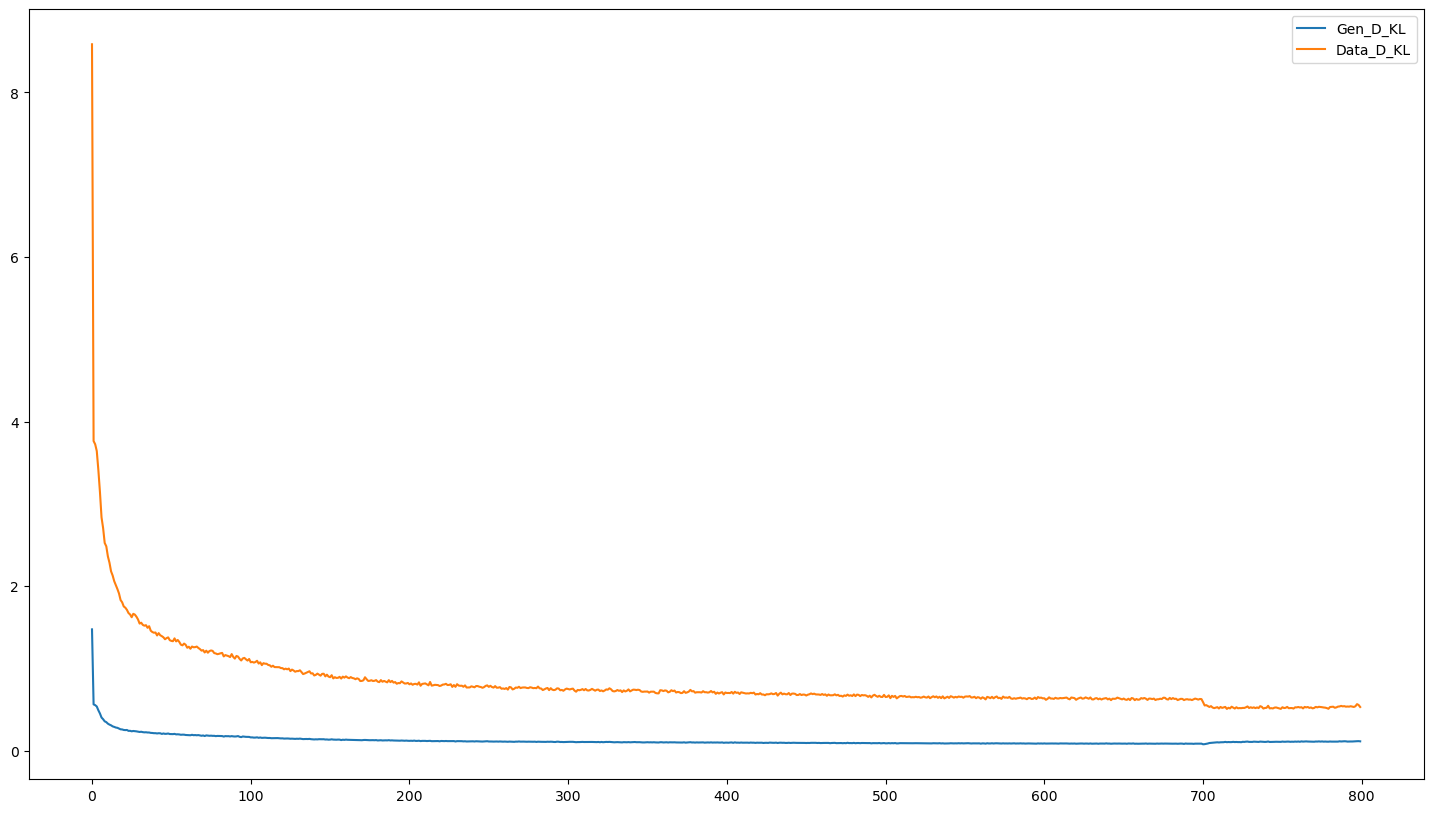

In [222]:
Analytic = Analytic_HM_test
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(np.array(Analytic['Gen_D_KL']),label = 'Gen_D_KL')
ax.plot(np.array(Analytic['Data_D_KL']),label = 'Data_D_KL')
ax.legend()
plt.show()

In [1216]:
np.array(Analytic['Data_D_KL'])[2100:]

array([0.57251632, 0.57234585, 0.57410616, 0.55409086, 0.55389792,
       0.5390988 , 0.5416351 , 0.5380097 , 0.53836733, 0.52961999,
       0.53577989, 0.52740359, 0.52129441, 0.52592134, 0.52472132,
       0.52021974, 0.53709674, 0.52488452, 0.5223453 , 0.52860582,
       0.52530378, 0.51896459, 0.52179873, 0.51723146, 0.53476429,
       0.51268095, 0.50974798, 0.51971501, 0.51317358, 0.51803511,
       0.51991922, 0.50399315, 0.52320623, 0.5380106 , 0.53234828,
       0.52193451, 0.5249151 , 0.52316165, 0.52066946, 0.51441813,
       0.53027344, 0.51594901, 0.51917481, 0.52583277, 0.51603663,
       0.51620299, 0.52815276, 0.51661205, 0.52584797, 0.51626092,
       0.52277762, 0.51812196, 0.52284098, 0.53055418, 0.52521122,
       0.51846224, 0.52796662, 0.51535994, 0.50686228, 0.51926583,
       0.51691657, 0.52320337, 0.51974094, 0.5126375 , 0.52774441,
       0.50659537, 0.51145089, 0.51333392, 0.52892822, 0.53452045,
       0.51227069, 0.50684649, 0.52394116, 0.52017576, 0.51473

In [400]:
# fig, ax = plt.subplots(figsize=(18, 10))
# ax.plot(np.array(Analytic['Accuracy'])[30:],label = 'Accuracy')
# ax.legend()
# plt.show()

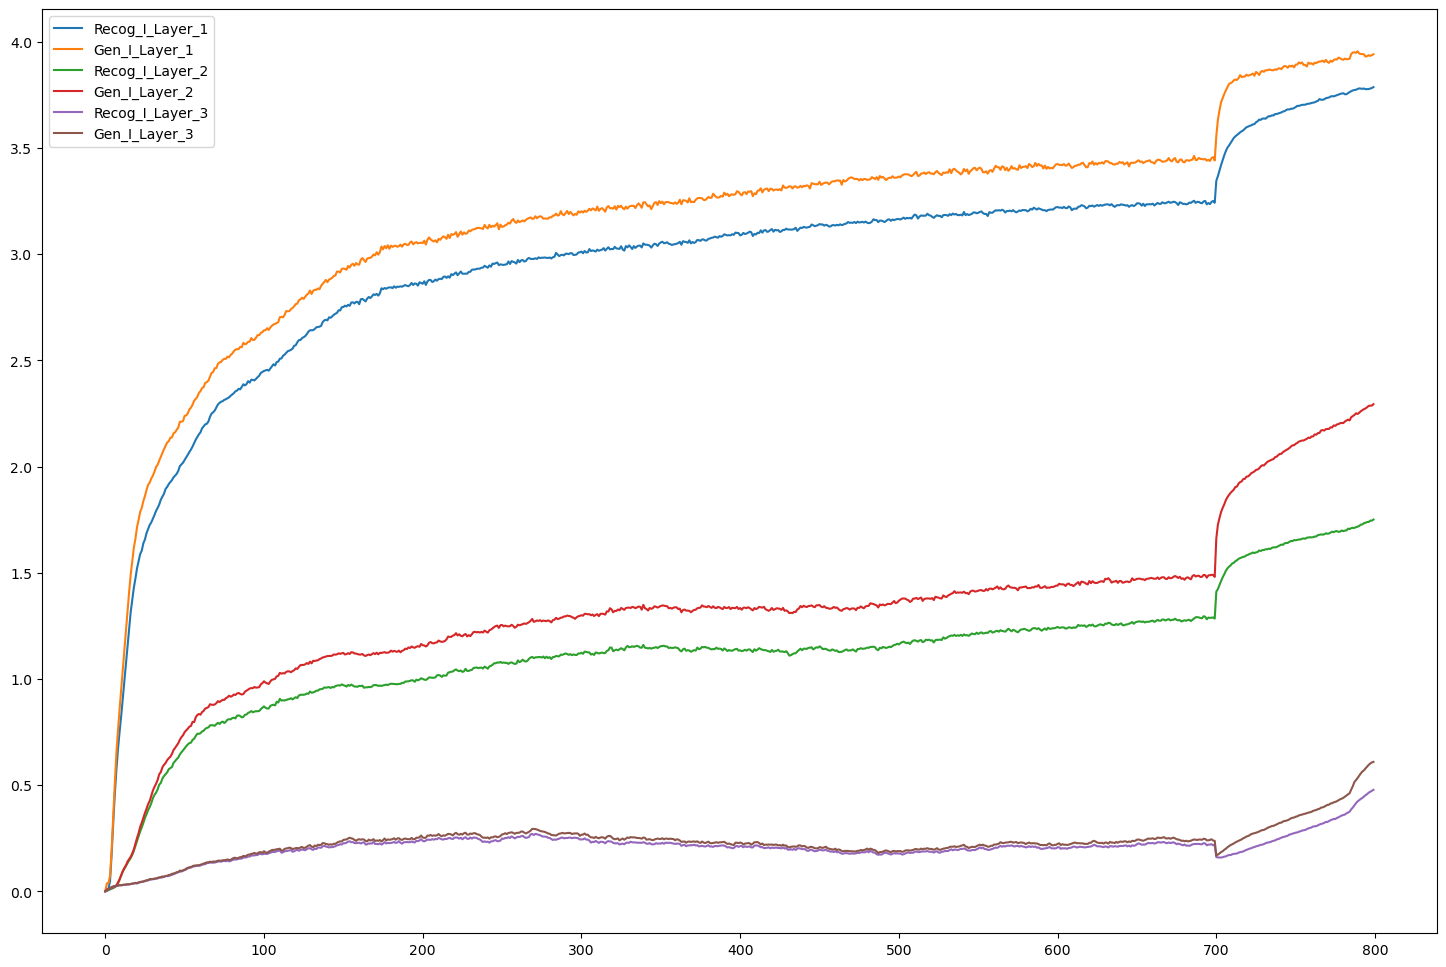

In [223]:
fig, ax = plt.subplots(figsize=(18, 12))
for i in range(1,n_layer-1):
    ax.plot(np.array(Analytic['Recog_I_Layer_'+str(i)]),label = 'Recog_I_Layer_'+str(i))
    ax.plot(np.array(Analytic['Gen_I_Layer_'+str(i)]),label = 'Gen_I_Layer_'+str(i))
ax.legend()
plt.show()

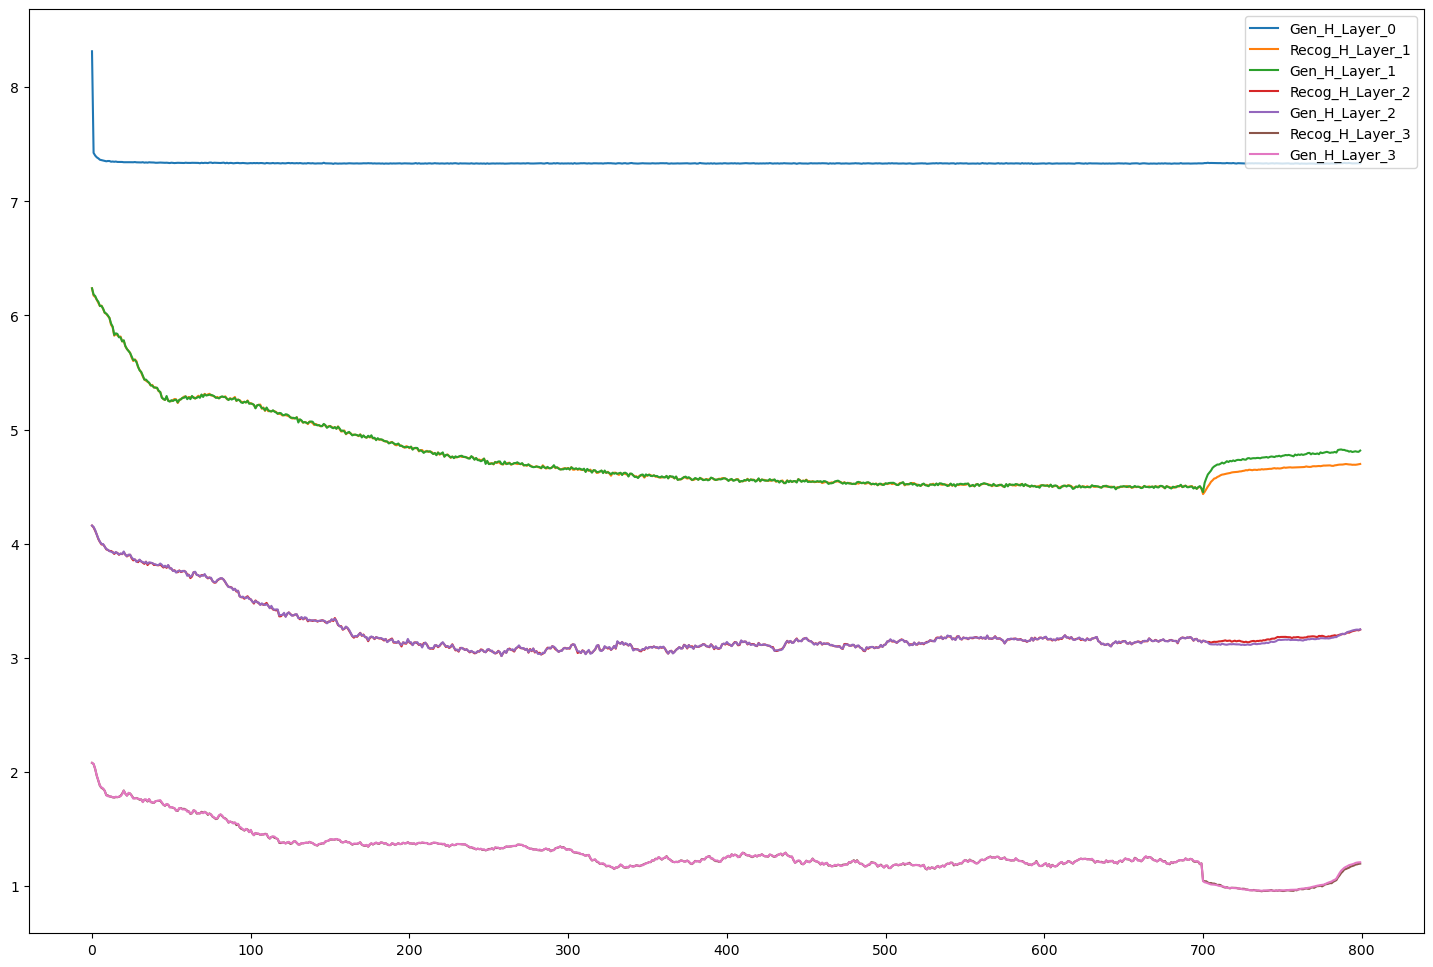

In [225]:
fig, ax = plt.subplots(figsize=(18, 12))
ax.plot(np.array(Analytic['Gen_H_Layer_0']),label = 'Gen_H_Layer_0')
for i in range(1,n_layer-1):
    ax.plot(np.array(Analytic['Recog_H_Layer_'+str(i)]),label = 'Recog_H_Layer_'+str(i))
    ax.plot(np.array(Analytic['Gen_H_Layer_'+str(i)]),label = 'Gen_H_Layer_'+str(i))
ax.legend()
plt.show()

In [226]:
n_dz[:-1] * np.log(2)

tensor([8.3178, 6.2383, 4.1589, 2.0794])

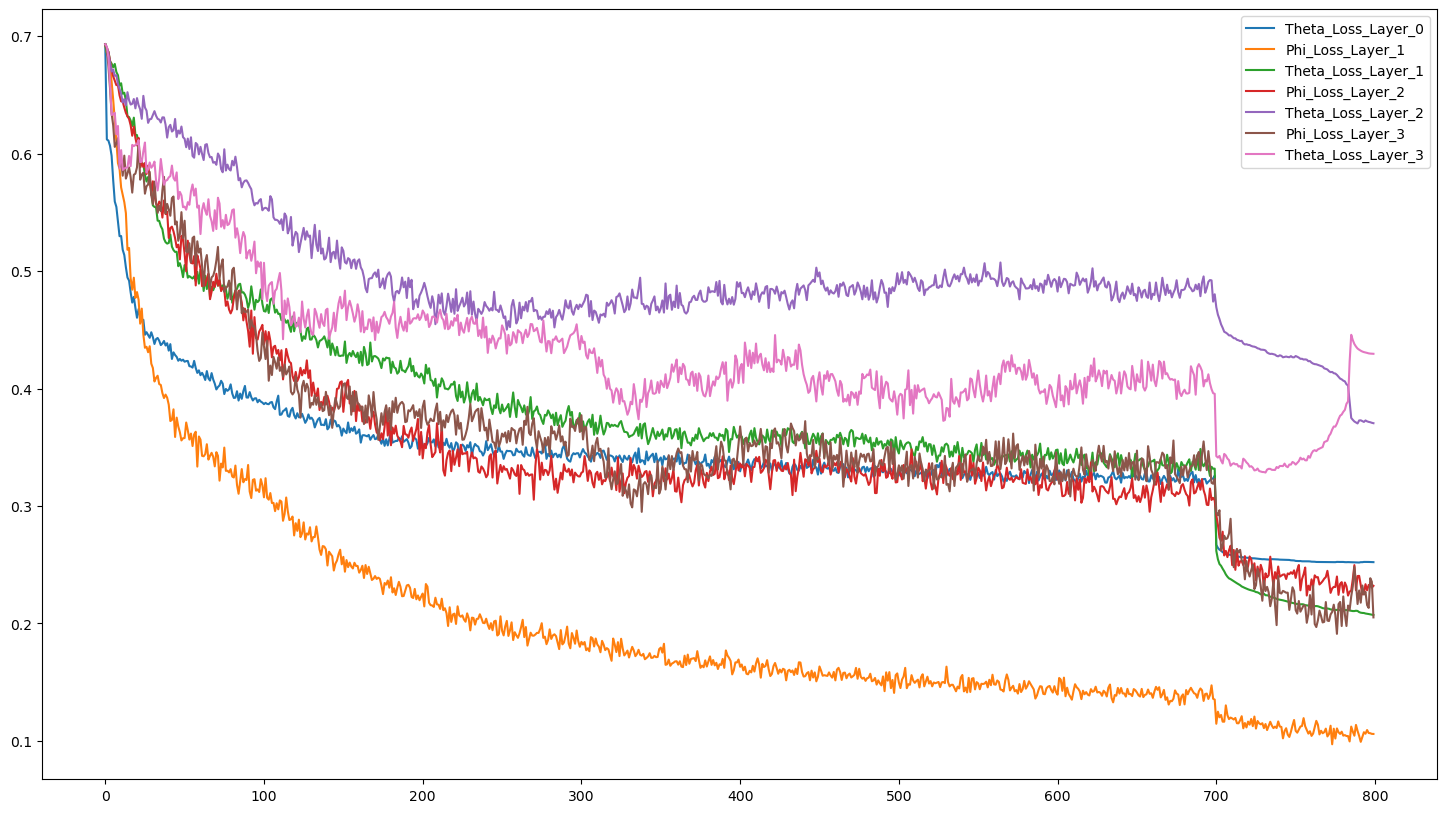

In [227]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(np.array(Analytic['Theta_Loss_Layer_'+str(0)]),label = 'Theta_Loss_Layer_'+str(0))
for i in range(1,n_layer-1):
    ax.plot(np.array(Analytic['Phi_Loss_Layer_'+str(i)]),label = 'Phi_Loss_Layer_'+str(i))
    ax.plot(np.array(Analytic['Theta_Loss_Layer_'+str(i)]),label = 'Theta_Loss_Layer_'+str(i))
ax.legend()
plt.show()

In [228]:
gen_batch_size = 100000
Recog_sample, H_Y_wake, H_YX_wake = wake_sample(Phi,data.repeat(1,100),dev)
Gen_sample, H_Y_sleep, H_YX_sleep = sleep_sample(Theta,gen_batch_size,dev)

In [229]:
print('H_Y_wake', H_Y_wake,'     H_YX_wake', H_YX_wake)
print('H_Y_sleep', H_Y_sleep,'     H_YX_sleep', H_YX_sleep)

H_Y_wake tensor([4.6991, 3.2456, 1.1998])      H_YX_wake tensor([0.9120, 1.4934, 0.7176])
H_Y_sleep tensor([7.3328, 4.7999, 3.2530, 1.2095])      H_YX_sleep tensor([3.4080, 2.5066, 2.6375, 1.2095])


Layer 0 Data_dist D_KL: 0.5484
Layer 0 Gen_dist D_KL: 0.1176
Layer 1 Recognition Distribution D_KL: 0.0484 H(Y): 4.6991 H(Y|X): 0.912 I_XY: 3.7871
Layer 1 Generative  Distribution D_KL: 0.0329 H(Y): 4.7999 H(Y|X): 2.5066 I_XY: 3.9248
Layer 2 Recognition Distribution D_KL: 0.0217 H(Y): 3.2456 H(Y|X): 1.4934 I_XY: 1.7522
Layer 2 Generative  Distribution D_KL: 0.0203 H(Y): 3.253 H(Y|X): 2.6375 I_XY: 2.2934
Layer 3 Recognition Distribution D_KL: 0.0008 H(Y): 1.1998 H(Y|X): 0.7176 I_XY: 0.4821
Layer 3 Generative  Distribution D_KL: 0.0008 H(Y): 1.2095 H(Y|X): 1.2095 I_XY: 0.6155


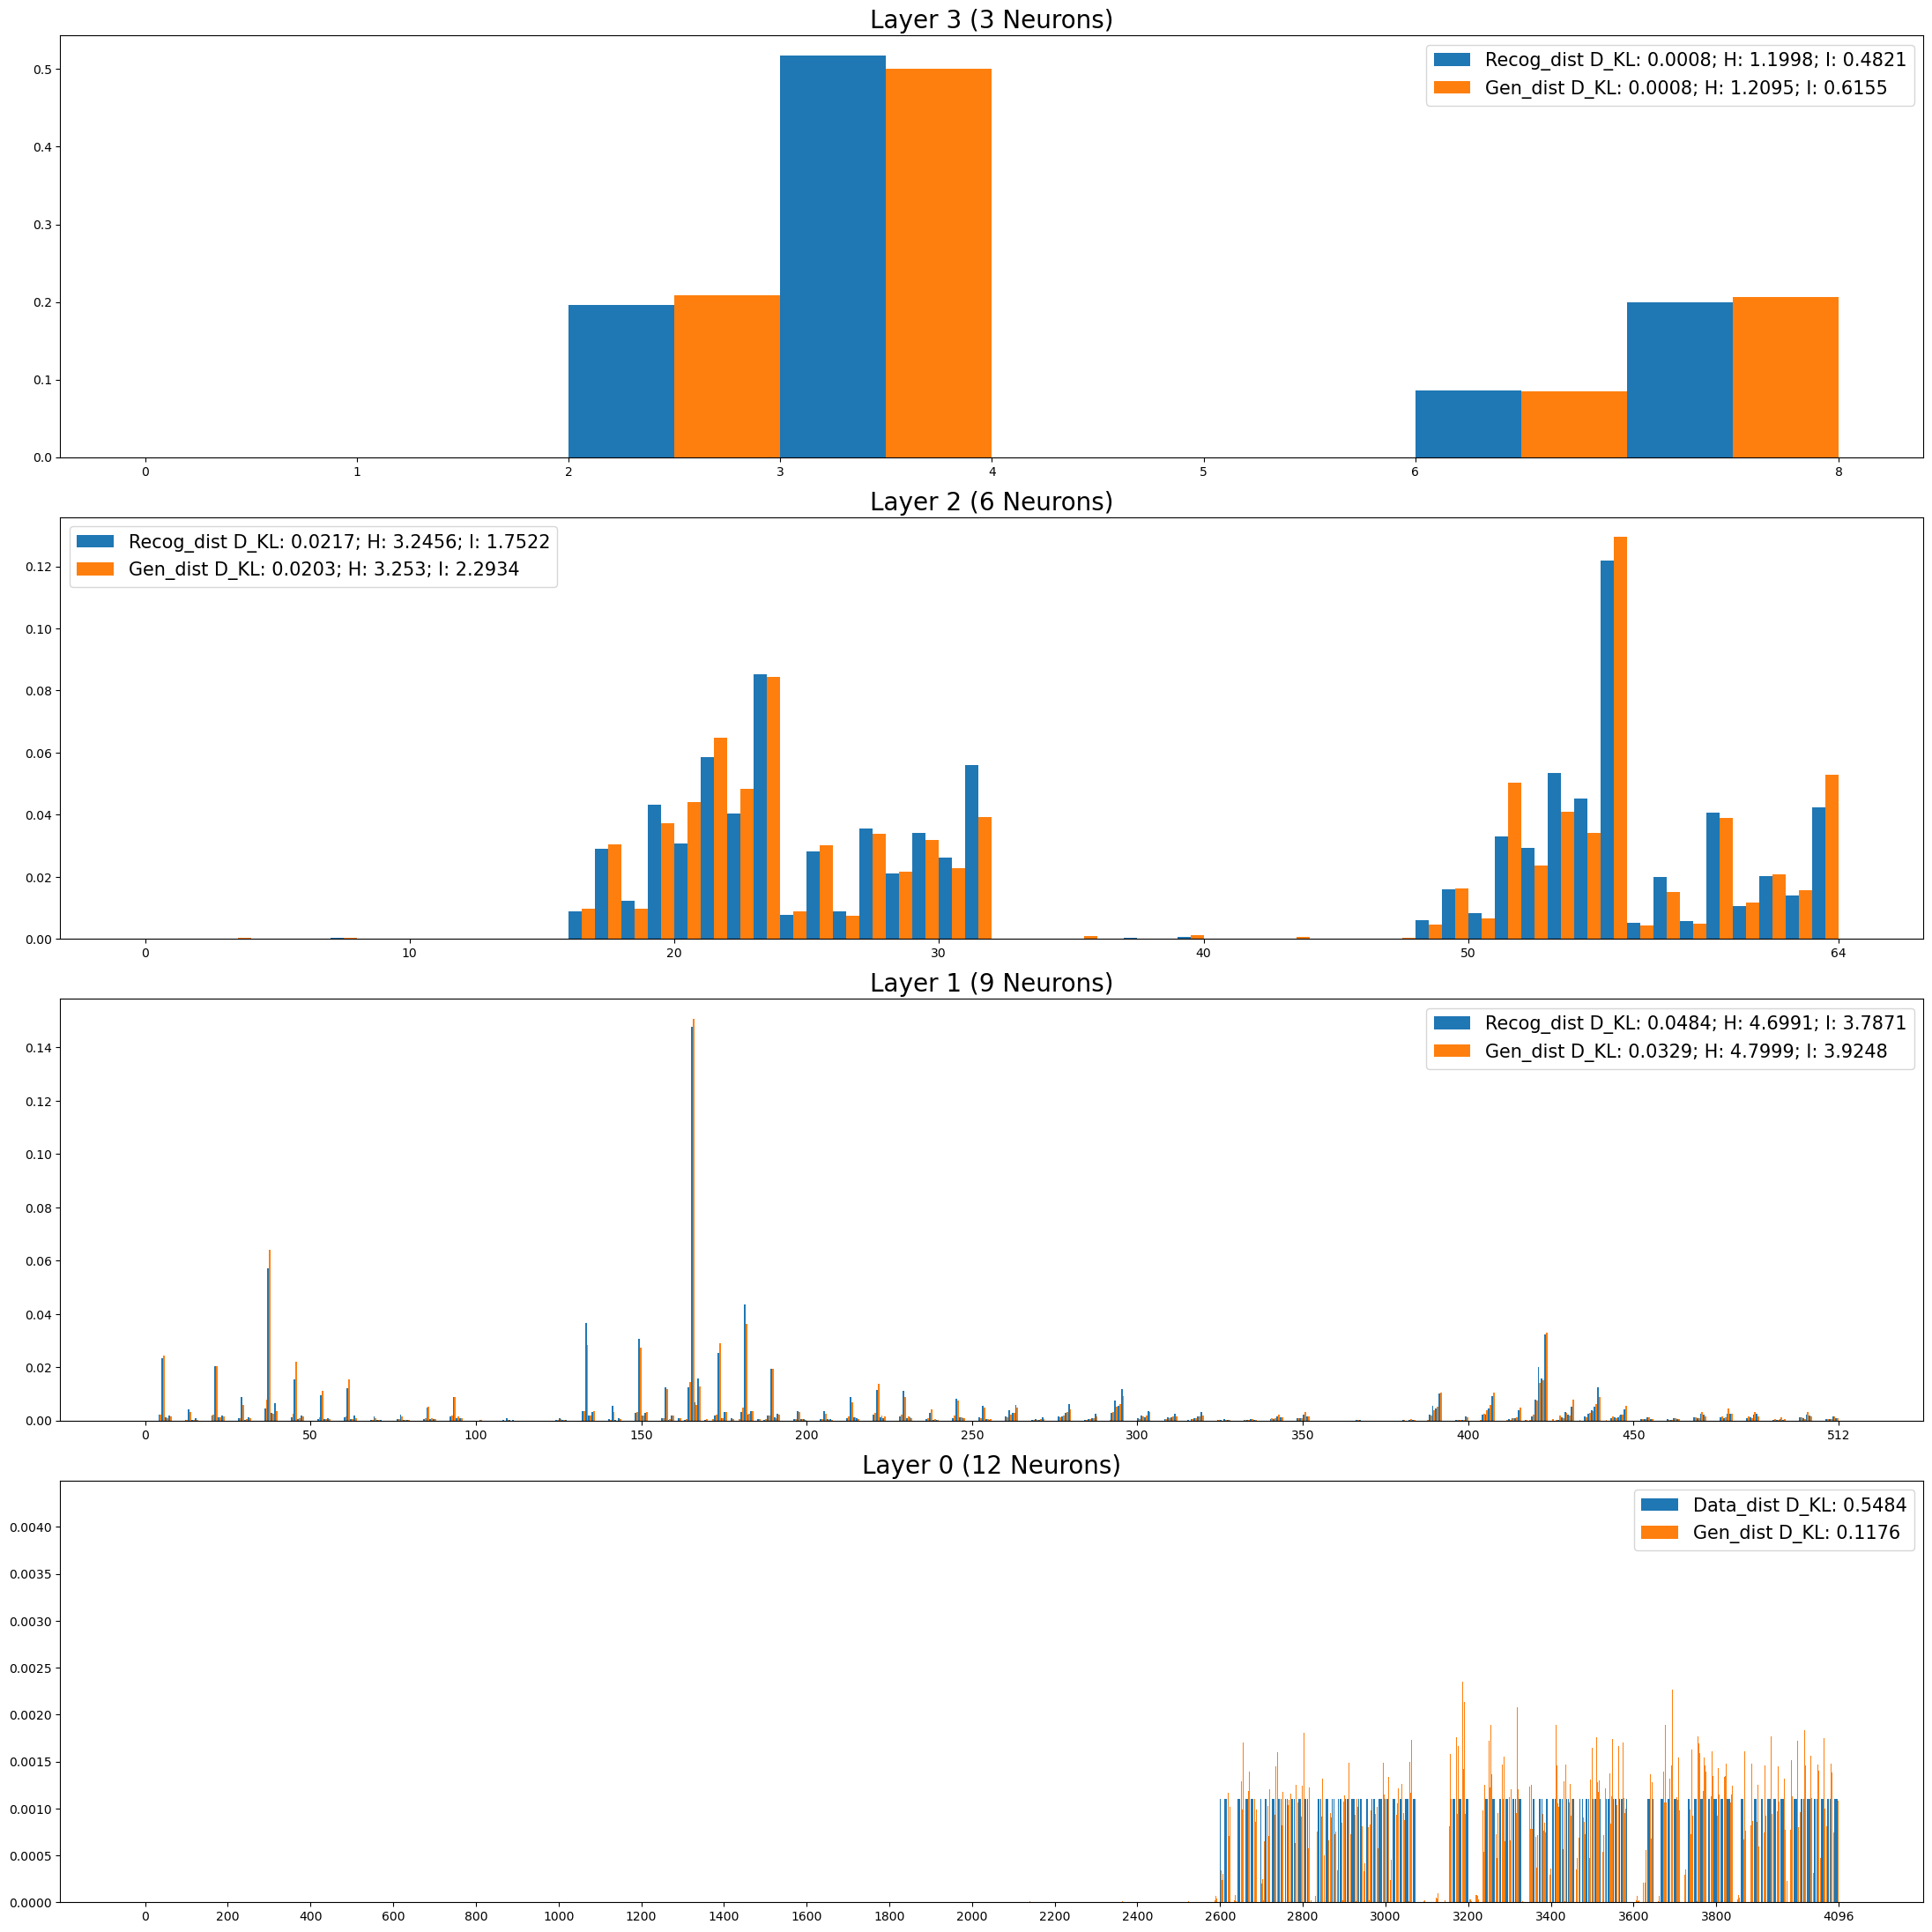

In [230]:
fig_ct, ax_ct = plt.subplots(n_layer-1, 1, figsize=(22, 22))
H_Y_wake = H_Y_wake.to('cpu').numpy()
H_YX_wake = H_YX_wake.to('cpu').numpy()
I_wake = H_Y_wake - H_YX_wake
H_Y_sleep = H_Y_sleep.to('cpu').numpy()
H_YX_sleep = H_YX_sleep.to('cpu').numpy()
I_sleep = H_Y_sleep - H_YX_sleep

for i in range(n_layer-1):
    smp = Recog_sample['Layer_'+str(i)]
    values_g,counts_g = torch.unique(decimalize(smp,dev),return_counts=True)
    dist_w = torch.zeros(2**smp.shape[0],device=dev)
    dist_w[values_g]=counts_g/smp.shape[1]
    
    smp = Gen_sample['Layer_'+str(i)]
    values_g,counts_g = torch.unique(decimalize(smp,dev),return_counts=True)
    dist_s = torch.zeros(2**smp.shape[0],device=dev)
    dist_s[values_g]=counts_g/smp.shape[1]
    
    D_KL_w = KL_divergence(dist_s,dist_w).item()
    D_KL_s = KL_divergence(dist_w,dist_s).item()
    
    if i > 0:
        print("Layer "+str(i), "Recognition Distribution D_KL: "+str(np.around(D_KL_w,4)),\
          "H(Y): "+str(np.around(H_Y_wake[i-1],4)), "H(Y|X): "+str(np.around(H_YX_wake[i-1],4)),"I_XY: "+str(np.around(I_wake[i-1],4)))
        print("Layer "+str(i),"Generative  Distribution D_KL: "+str(np.around(D_KL_s,4)),\
          "H(Y): "+str(np.around(H_Y_sleep[i],4)), "H(Y|X): "+str(np.around(H_YX_sleep[i],4)),"I_XY: "+str(np.around(I_sleep[i-1],4)))
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[i]),dist_w.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Recog_dist D_KL: " + str(np.around(D_KL_w,4))+"; H: "+ \
                               str(np.around(H_Y_wake[i-1],4))+ "; I: "+ str(np.around(I_wake[i-1],4)))
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[i])+0.5,dist_s.to('cpu').numpy(),width=0.5,align='edge',\
                          label = "Gen_dist D_KL: " + str(np.around(D_KL_s,4))+"; H: "+ \
                               str(np.around(H_Y_sleep[i],4))+ "; I: "+ str(np.around(I_sleep[i-1],4)))
    else:
        print("Layer "+str(i), "Data_dist D_KL: "+str(np.around(D_KL_w,4)))
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[i]),dist_w.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Data_dist D_KL: " + str(np.around(D_KL_w,4)))
        
        print("Layer "+str(i), "Gen_dist D_KL: "+str(np.around(D_KL_s,4)))
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[i])+0.5,dist_s.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Gen_dist D_KL: " + str(np.around(D_KL_s,4)))

    ax_ct[n_layer-2-i].set_title("Layer "+str(i)+" ("+ str(n_dz[i].item())+" Neurons)",fontsize=20)
    ax_ct[n_layer-2-i].legend(fontsize=15)
    
    x_lim = 2**(n_dz[n_layer-2-i])
    if i==0:
        xtick = np.arange(0,x_lim)
    elif i==1:
        xtick = np.arange(0,x_lim,10)
    elif i==2:
        xtick = np.arange(0,x_lim,50)
    elif i==3:
        xtick = np.arange(0,x_lim,200)
    elif i==4:
        xtick = np.arange(0,x_lim,1000)    
    xtick[-1] = x_lim
    ax_ct[i].set(xticks=xtick)

plt.tight_layout(pad=1)    
plt.show()

Layer 0 Data_dist D_KL: -0.0179
Layer 0 Gen_dist D_KL: 0.0198
Layer 1 Recognition Distribution D_KL: 0.0087 H(Y): 4.6991 H(Y|X): 0.912 I_XY: 3.7871
Layer 1 Generative  Distribution D_KL: -0.0054 H(Y): 4.7999 H(Y|X): 2.5066 I_XY: 3.9248
Layer 2 Recognition Distribution D_KL: -0.0163 H(Y): 3.2456 H(Y|X): 1.4934 I_XY: 1.7522
Layer 2 Generative  Distribution D_KL: 0.0169 H(Y): 3.253 H(Y|X): 2.6375 I_XY: 2.2934
Layer 3 Recognition Distribution D_KL: -0.0052 H(Y): 1.1998 H(Y|X): 0.7176 I_XY: 0.4821
Layer 3 Generative  Distribution D_KL: 0.0055 H(Y): 1.2095 H(Y|X): 1.2095 I_XY: 0.6155


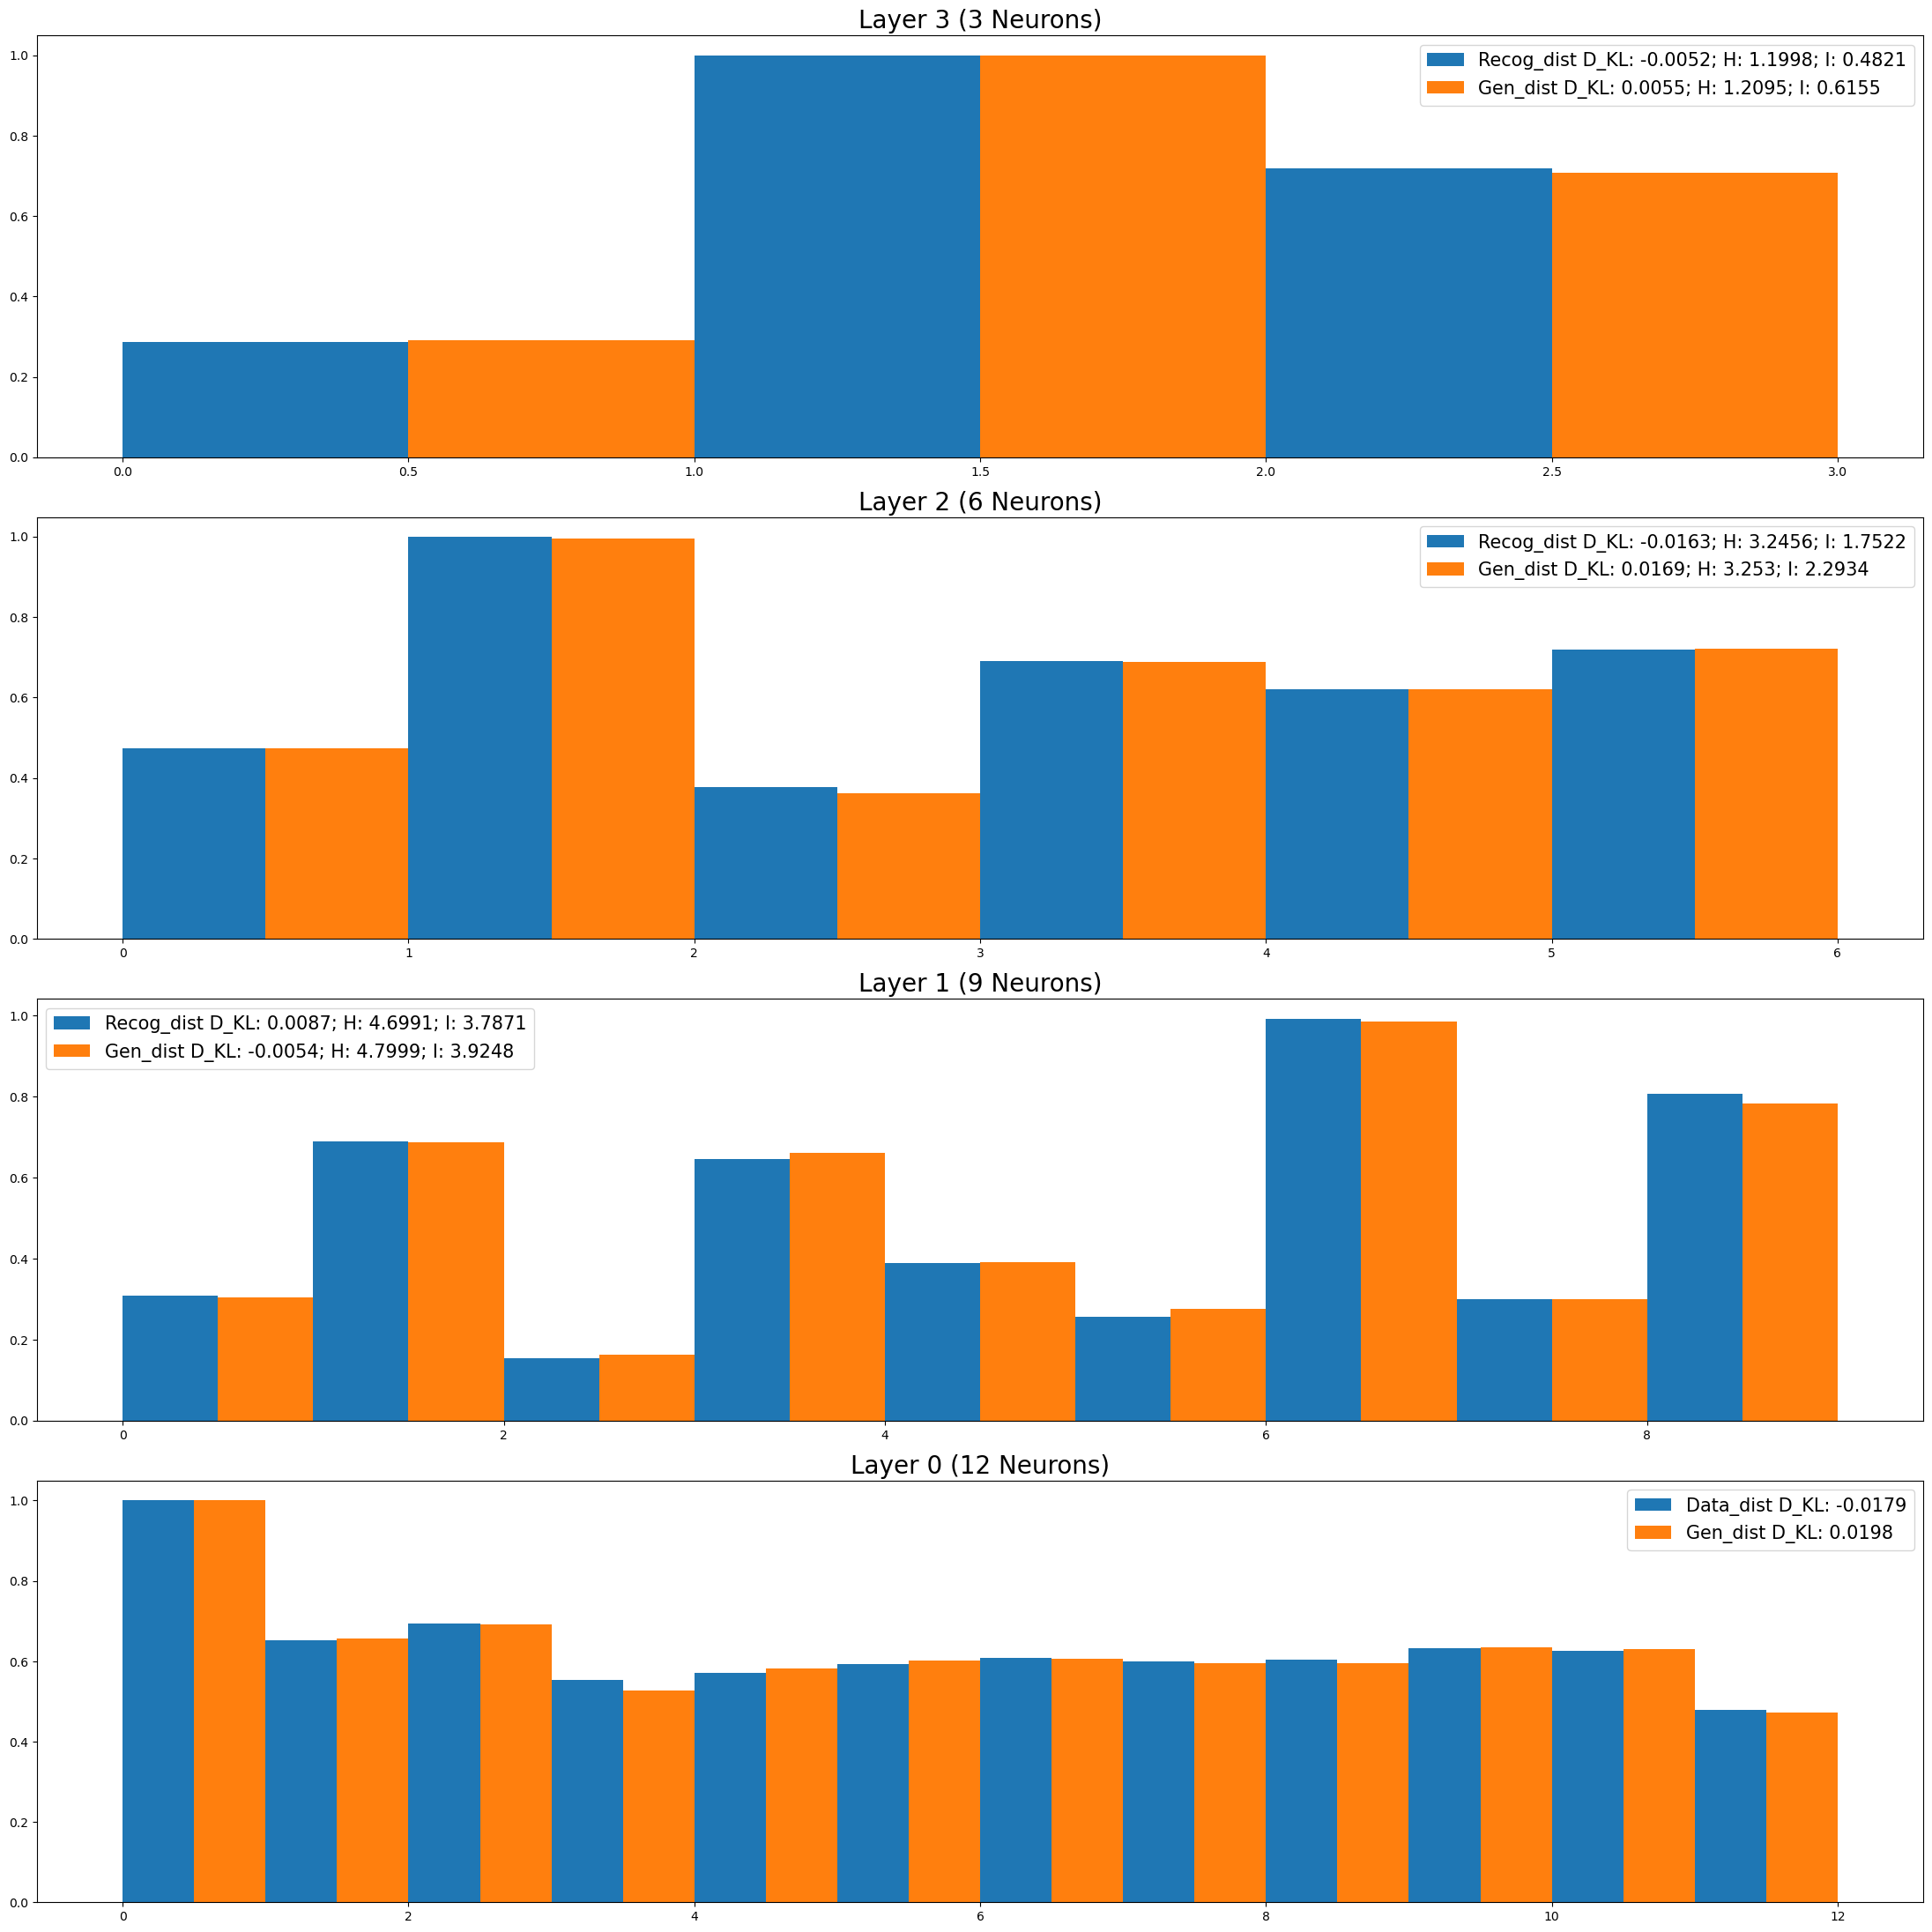

In [231]:
fig_ct, ax_ct = plt.subplots(n_layer-1, 1, figsize=(22, 22))

for i in range(n_layer-1):
    dist_w = Recog_sample['Layer_'+str(i)].float().mean(axis=1)
    dist_s = Gen_sample['Layer_'+str(i)].float().mean(axis=1)
    D_KL_w = KL_divergence(dist_s,dist_w).item()
    D_KL_s = KL_divergence(dist_w,dist_s).item()
    
    if i > 0:
        print("Layer "+str(i), "Recognition Distribution D_KL: "+str(np.around(D_KL_w,4)),\
          "H(Y): "+str(np.around(H_Y_wake[i-1],4)), "H(Y|X): "+str(np.around(H_YX_wake[i-1],4)),"I_XY: "+str(np.around(I_wake[i-1],4)))
        print("Layer "+str(i),"Generative  Distribution D_KL: "+str(np.around(D_KL_s,4)),\
          "H(Y): "+str(np.around(H_Y_sleep[i],4)), "H(Y|X): "+str(np.around(H_YX_sleep[i],4)),"I_XY: "+str(np.around(I_sleep[i-1],4)))
        ax_ct[n_layer-2-i].bar(np.arange(n_dz[i]),dist_w.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Recog_dist D_KL: " + str(np.around(D_KL_w,4))+"; H: "+ \
                               str(np.around(H_Y_wake[i-1],4))+ "; I: "+ str(np.around(I_wake[i-1],4)))
        ax_ct[n_layer-2-i].bar(np.arange(n_dz[i])+0.5,dist_s.to('cpu').numpy(),width=0.5,align='edge',\
                          label = "Gen_dist D_KL: " + str(np.around(D_KL_s,4))+"; H: "+ \
                               str(np.around(H_Y_sleep[i],4))+ "; I: "+ str(np.around(I_sleep[i-1],4)))
    else:
        print("Layer "+str(i), "Data_dist D_KL: "+str(np.around(D_KL_w,4)))
        ax_ct[n_layer-2-i].bar(np.arange(n_dz[i]),dist_w.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Data_dist D_KL: " + str(np.around(D_KL_w,4)))
        
        print("Layer "+str(i), "Gen_dist D_KL: "+str(np.around(D_KL_s,4)))
        ax_ct[n_layer-2-i].bar(np.arange(n_dz[i])+0.5,dist_s.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Gen_dist D_KL: " + str(np.around(D_KL_s,4)))

    ax_ct[n_layer-2-i].set_title("Layer "+str(i)+" ("+ str(n_dz[i].item())+" Neurons)",fontsize=20)
    ax_ct[n_layer-2-i].legend(fontsize=15)
    
plt.tight_layout(pad=1)    
plt.show()

In [80]:
scheduled_sample = wake_sample_deterministic(Phi,data,dev)

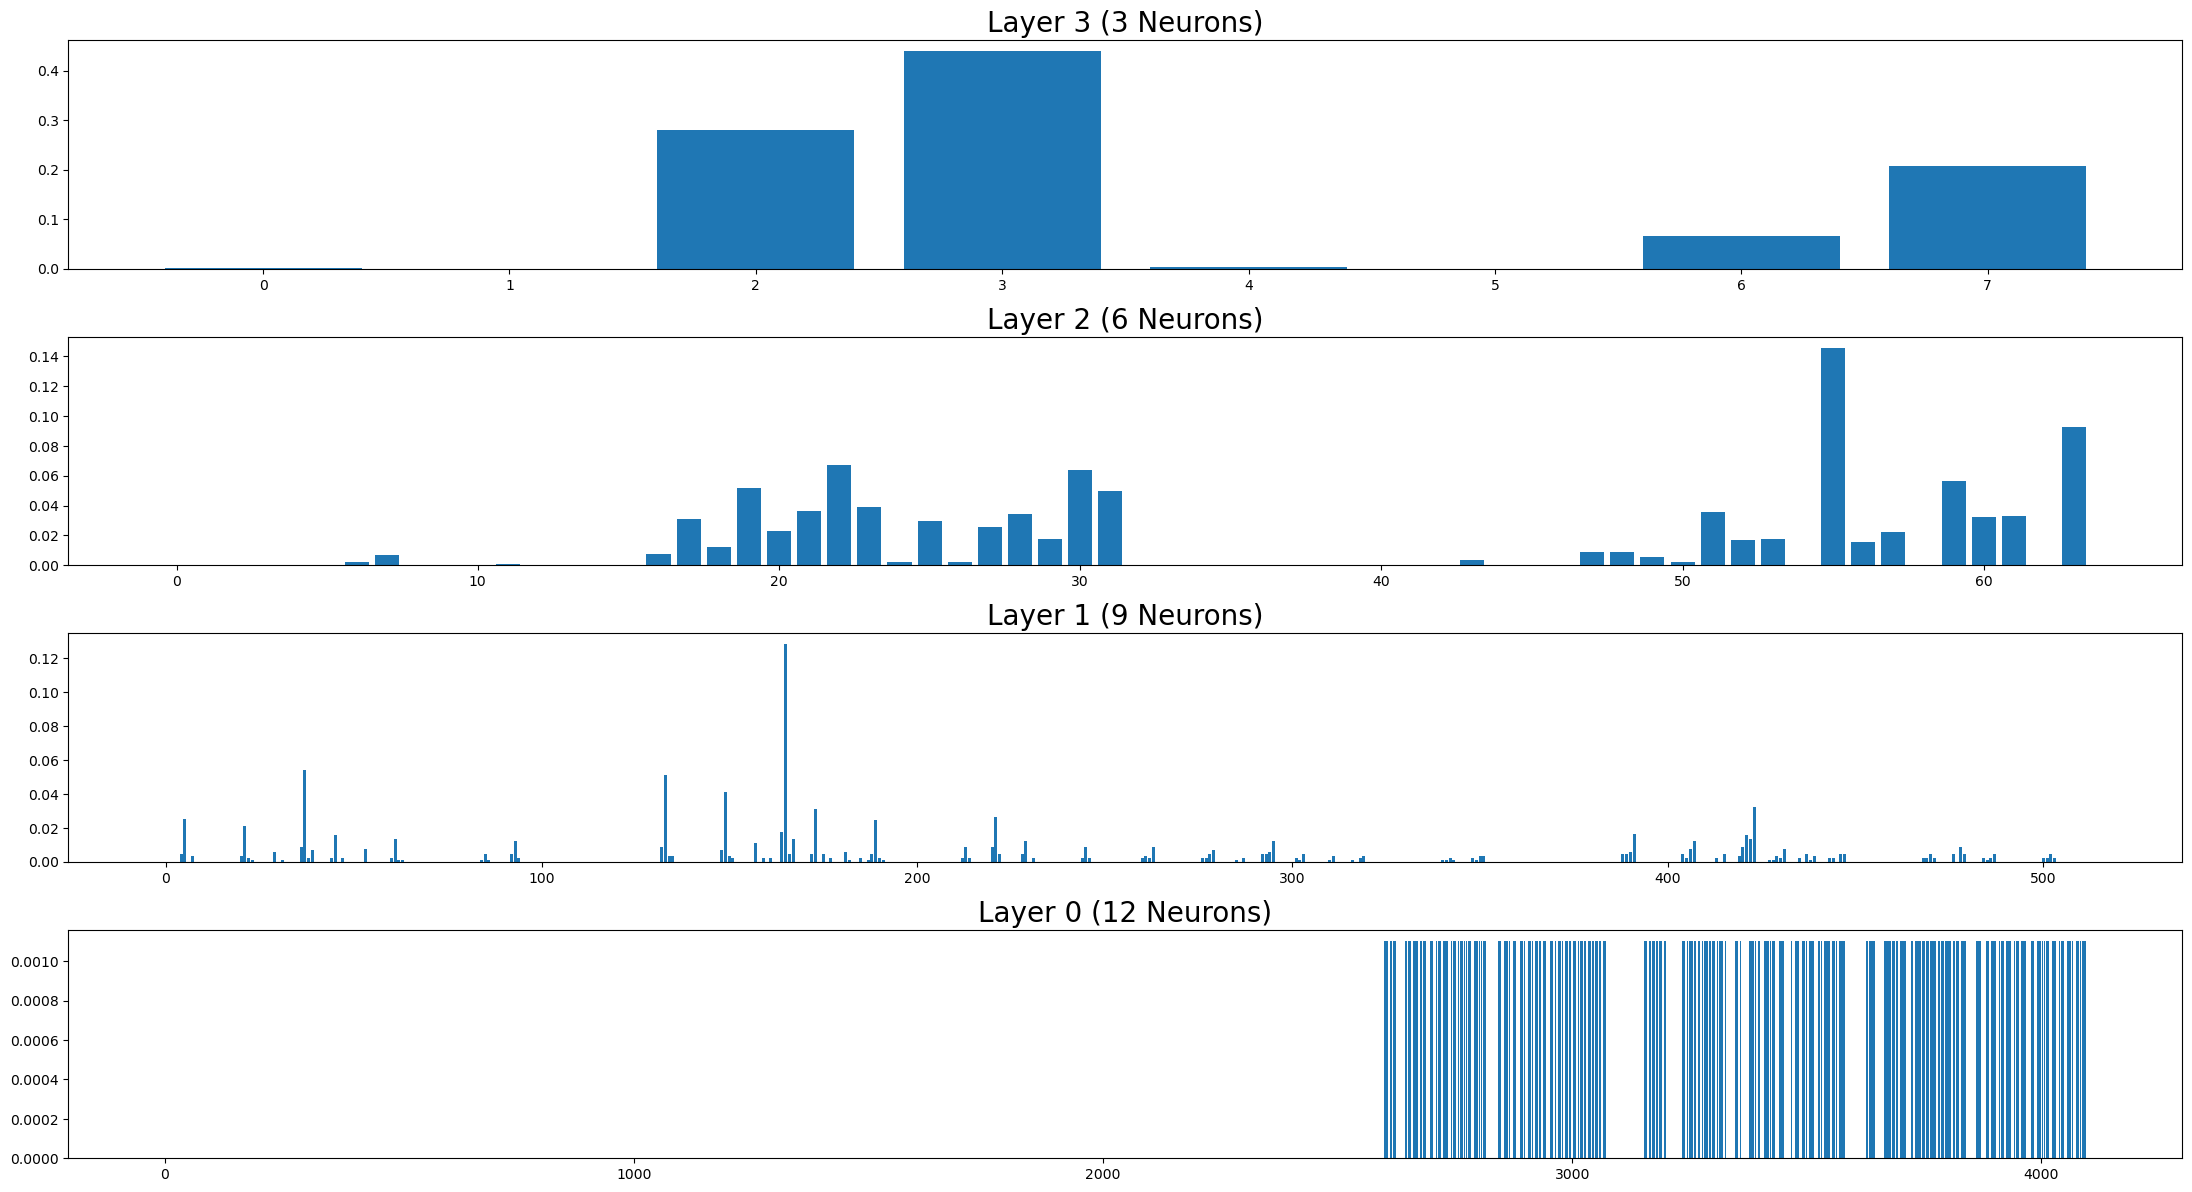

In [82]:
fig_ct, ax_ct = plt.subplots(n_layer-1, 1, figsize=(22, 12))
for i in range(n_layer-1):
    smp = scheduled_sample['Layer_'+str(i)]
    values_g,counts_g = torch.unique(decimalize(smp,dev),return_counts=True)
    dist = torch.zeros(2**smp.shape[0],device=dev)
    dist[values_g]=counts_g/smp.shape[1]
    
    ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[i]),dist.to('cpu').numpy(), label = 'Layer_'+str(i))
    ax_ct[n_layer-2-i].set_title("Layer "+str(i)+" ("+ str(n_dz[i].item())+" Neurons)",fontsize=20)
plt.tight_layout(pad=1)    
plt.show()